In [1]:
%reset -f

In [2]:
from bs4 import BeautifulSoup
import nbformat
from nbformat.v4 import output_from_msg
from nbconvert.preprocessors import ExecutePreprocessor
import markdown

# Lire le notebook
with open("feature_engineering.ipynb") as f:
    nb = nbformat.read(f, as_version=4)

# Récupérer le contenu Markdown des cellules
md_content = ""
for cell in nb.cells:
    if cell.cell_type == "markdown":
        md_content += cell.source + "\n"

# Parser le contenu Markdown pour extraire les titres
html_content = markdown.markdown(md_content)
title_tags = ["h1", "h2", "h3", "h4", "h5", "h6"]
titles = [t.text for t in BeautifulSoup(html_content, "html.parser").find_all(title_tags)]

# Afficher les titres et créer un sommaire
print("Titres :")
for title in titles:
    print(title)

print("Sommaire :")
for i, title in enumerate(titles):
    print(f"{i+1}. {title}")


Titres :
Traitement du dataframe app_train
Traitement du dataframe balance
Traitement du dataframe bureau
Fusion des tables balance et bureau
Fusion du dataframe app_train et bureau_balance
Traitement du dataframe cc_balance
Fusion du dataframe data_final et cc_balance
Traitement du dataframe installmnt
Fusion du dataframe data_final et installmnt
Traitement du dataframe POS
Traitement du dataframe prv_app
Fusion du dataframe data_final et prev_app
Traitement du dataframe sample
Exploration du dataframe data_final
Traitement des valeurs
Traitement des outliers
Passage des valeurs de la feature AMT_CREDIT_SUM_DEBT au positif
Tri de feature
Modification de valeurs
Feature NAME_EDUCATION_TYPE
Feature NAME_FAMILY_STATUS
Feature NAME_HOUSING_TYPE
Feature ORGANIZATION_TYPE
Feature NAME_CONTRACT_TYPE
Feature CREDIT_TYPE
Feature NAME_CONTRACT_TYPE_PREV
Feature NAME_INCOME_TYPE
Feature OCCUPATION_TYPE
Feature CREDIT ACTIVE
Contrôle des NaN
Contrôle de mémoire
Conversion des types de fichiers in

In [3]:
import numpy as np
import pandas as pd 
import moduleexplo

from tabulate import tabulate

from sklearn.preprocessing import LabelEncoder

import os
 
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import datetime
now  = datetime.datetime.now().isoformat()

print('Lancé le      : ' + now)

Lancé le      : 2023-09-04T11:14:22.328400


In [4]:
# Réglage de l'affichage de données
pd.set_option('display.max_row',250)
pd.set_option('display.max_column',300)
pd.set_option('display.precision', 5)

In [5]:
# Affichage des informations du dataframe
def info(df):

    display(df.head(3))
    print(f'Taille :-------------------------------------------------------------- {df.shape}')
    print("--"*50)
    print(f'Types :{df.dtypes.value_counts()}')
    print("--"*50)
    print(f'Types :{df.dtypes}')
    print("--"*50)
    print("Valeurs manquantes par colonnes (%): ")
    print((((df.isna().sum()/df.shape[0])*100).round(2)).sort_values(ascending=False))
    print("--"*50)
    print("Valeurs différentes par variables : ")
    for cols in df:
        if df[cols].nunique() < 30:
            print(f'{cols :-<70} {df[cols].unique()}')
        else:
            print(f'{cols :-<70} contient {df[cols].nunique()} valeurs différentes')
    print("--"*50)
    print(f"Nombre de doublons : {df.duplicated().sum()}")


# Fonction de comptage de lignes et de colonne du dataset, affichage d'une representation\
# graphique des sonnées manquantes

def valeurs(df):

    # Affichage du nombre de lignes et de colonnes
    lignes = len(df.index)
    colonnes = len(df.columns)
    print('Le nombre de lignes du fichier est de ', lignes, 'et de son nombre de colonnes est de', colonnes)

    # Representation graphique des données manquantes
    sns.set(rc={'figure.figsize': (20, 10)})
    sns.heatmap(df.isnull(), cbar=False)
    plt.rcParams.update({'font.size': 30})
    plt.tight_layout()
    plt.title('Representation graphique des valeurs manquantes', size=15)
    plt.plot()


def manquant(df):

    # Affichage des colonnes pour lesquelles il manque des données en pourcentage
    nb_na_sum = df.isnull().sum()
    round(nb_na_sum[nb_na_sum > 0]*100, 2).sort_values(ascending=True)
    print(nb_na_sum)
    # Affichage des colonnes pour lesquelles il manque des données en pourcentage
    nb_na = df.isnull().mean()
    round(nb_na[nb_na > 0]*100, 2).sort_values(ascending=True)
    print(nb_na)
    # Taux de remplissage moyen
    nulles = df.isnull().sum().sum()
    nb_donnees_tot = np.product(df.shape)
    pourcentage_valeurs = round(df.isna().sum().sum() / df.size * 100, 2)
    print('Le jeu de données contient', nulles, 'valeurs manquantes pour ', nb_donnees_tot, 'valeurs, soit',
          pourcentage_valeurs, '%')


# Format des données
def format_data(df):

    # On affiche le format des données
    print(df.shape[0], "produits")
    print(df.shape[1], "variables")
    print("\nType des variables:\n", df.dtypes.value_counts())
    # On affiche un graphique
    df.dtypes.value_counts().plot.pie()
    plt.title('Répartition du type de variable', size=15)
    plt.plot()


def doublons(df, colonne):
    # Ne pas oublier les '' dans le nom de la colonne
    data_doublons = df.loc[:, colonne:].columns
    data_double = df.duplicated(subset=data_doublons, keep='first').value_counts()
    return data_double


# fonction pour afficher la table de description statistique
def stat_descriptives(df, variables):
    warnings.filterwarnings('ignore')
    """
    Statistiques descriptives moyenne, médiane, variance, écart-type,
    skewness et kurtosis du dataframe transmis en paramètre
    ----------
    @param IN : dataframe : DataFrame, obligatoire
                liste_variables : colonne dont on veut voir les stat descr
    @param OUT : dataframe des statistiques descriptives
    """
    liste_mean = ['mean']
    liste_median = ['median']
    liste_var = ['var']
    liste_std = ['std']
    liste_skew = ['skew']
    liste_kurtosis = ['kurtosis']
    liste_mode = ['mode']
    liste_cols = ['Desc']
    liste_max = ['Max']
    liste_min = ['Min']

    for col in variables:
        liste_mean.append(df[col].mean())
        liste_median.append(df[col].median())
        liste_var.append(df[col].var(ddof=0))
        liste_std.append(df[col].std(ddof=0))
        liste_skew.append(df[col].skew())
        liste_kurtosis.append(df[col].kurtosis())
        liste_cols.append(col)
        liste_mode.append(df[col].mode().to_string())
        liste_min.append(df[col].min())
        liste_max.append(df[col].max())

    data_stats = [liste_mean, liste_median, liste_var, liste_std, liste_skew,
                  liste_kurtosis, liste_mode, liste_min, liste_max]
    df_stat = pd.DataFrame(data_stats, columns=liste_cols)

    return df_stat.style.hide_index()

import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

def distribution(dataset):
    warnings.filterwarnings('ignore')

    sns.set_context("talk")
    sns.set_style("whitegrid")
    
    num_cols = dataset.select_dtypes(include=[np.number]).columns
    num_features = len(num_cols)
    
    fig, axes = plt.subplots(nrows=int(np.ceil(num_features / 3)), ncols=3, figsize=(21, 6 * int(np.ceil(num_features / 3))))
    axes = axes.flatten()

    for i, colonne in enumerate(num_cols):
        ax = axes[i]

        column_data = dataset[colonne].copy()
        column_data.replace([np.inf, -np.inf], np.nan, inplace=True)
        column_data.dropna(inplace=True)

        bins = int(np.sqrt(len(column_data)))
        kstest = stats.kstest(column_data, 'norm')
        sns.distplot(column_data, fit=stats.norm, kde=False, bins=bins, ax=ax)
        ax.set_title("Distribution vs loi normale : {}".format(colonne))
        ax.text(1, 1, 'Test Kolmogorov-Smirnov \n Pvalue: {:.2} \n Stat: {:.2}'.format(kstest.pvalue,
                                                                                         kstest.statistic),
                horizontalalignment='right',
                verticalalignment='top',
                style='italic', transform=ax.transAxes, fontsize=12,
                bbox={'facecolor': '#00afe6', 'alpha': 0.5, 'pad': 0})

    fig.tight_layout()
    plt.show()


def distib_feature(dataframe, feature):
    plt.figure(figsize=(10, 6))
    plt.title("Distribution de %s" % feature)
    sns.distplot(dataframe[feature].dropna(), kde=True, bins=100)
    plt.show()


In [6]:
#Importation du jeu de données
missing_values = ["n/a", "na", "--","nan","NaN"]
app_test = pd.read_csv('/Users/xparisot/Formation_OpenClassroom/Projets/Projet_7/datasets/data_app_test.csv', decimal=".", index_col=0, encoding='utf_8', low_memory=False,na_values = missing_values).reset_index()
app_train = pd.read_csv('/Users/xparisot/Formation_OpenClassroom/Projets/Projet_7/datasets/data_app_train.csv', decimal=".", index_col=0, encoding='utf_8', low_memory=False,na_values = missing_values).reset_index()
balance = pd.read_csv('/Users/xparisot/Formation_OpenClassroom/Projets/Projet_7/datasets/data_balance.csv', decimal=".", index_col=0, encoding='utf_8', low_memory=False,na_values = missing_values).reset_index()
bureau = pd.read_csv('/Users/xparisot/Formation_OpenClassroom/Projets/Projet_7/datasets/data_bureau.csv', decimal=".", index_col=0, encoding='utf_8', low_memory=False,na_values = missing_values).reset_index()
cc_balance = pd.read_csv('/Users/xparisot/Formation_OpenClassroom/Projets/Projet_7/datasets/data_cc_balance.csv', decimal=".", index_col=0, encoding='utf_8', low_memory=False,na_values = missing_values).reset_index()
installmnt = pd.read_csv('/Users/xparisot/Formation_OpenClassroom/Projets/Projet_7/datasets/data_installmnt.csv', decimal=".", index_col=0, encoding='utf_8', low_memory=False,na_values = missing_values).reset_index()
POS = pd.read_csv('/Users/xparisot/Formation_OpenClassroom/Projets/Projet_7/datasets/data_POS.csv', decimal=".", index_col=0, encoding='utf_8', low_memory=False,na_values = missing_values).reset_index()
prv_app = pd.read_csv('/Users/xparisot/Formation_OpenClassroom/Projets/Projet_7/datasets/data_prv_app.csv', decimal=".", index_col=0, encoding='utf_8', low_memory=False,na_values = missing_values).reset_index()
sample = pd.read_csv('/Users/xparisot/Formation_OpenClassroom/Projets/Projet_7/datasets/data_sample.csv', decimal=".", index_col=0, encoding='utf_8', low_memory=False,na_values = missing_values).reset_index()
hc_desc = pd.read_csv('/Users/xparisot/Formation_OpenClassroom/Projets/Projet_7/datasets/HomeCredit_columns_description.csv', decimal=".", index_col=None, encoding='latin1', low_memory=False, na_values=missing_values).reset_index()

In [7]:
#Format de pourcentage avec 2 virgules en décimale
def format_percentage(value):
    return "{0:.2f}%".format(value * 100)

Nous allons maintenant préparer notre dataframe final en traitant les différents fichiers par la supression, fusion, et renommage de features et/ou de valeurs. 

# Traitement du dataframe app_train

In [8]:
print(app_train.shape)

(307511, 122)


In [9]:
app_train['SK_ID_CURR'].dtypes

dtype('int64')

In [10]:
view_train = app_train.head(10).T
print(tabulate(view_train))

----------------------------  -----------------------------  -----------------  -----------------------------  -----------------------------  -----------------------------  -----------------------------  ----------------------  -----------------  -----------------------------  -----------------------------
SK_ID_CURR                    100002                         100003             100004                         100006                         100007                         100008                         100009                  100010             100011                         100012
TARGET                        1                              0                  0                              0                              0                              0                              0                       0                  0                              0
NAME_CONTRACT_TYPE            Cash loans                     Cash loans         Revolving loans                Cash loans      

Nous allons créer des listes afin de supprimer les informations non nécessaires à notre projet. Les listes nous permettrons une gestion plus fine des features. Si besoin. 

In [11]:
# Création de liste de colonnes à supprimer 
# Données relatives au logement
facilities_list = ['APARTMENTS_AVG','BASEMENTAREA_AVG','YEARS_BEGINEXPLUATATION_AVG','YEARS_BUILD_AVG',
                             'COMMONAREA_AVG','ELEVATORS_AVG','ENTRANCES_AVG','FLOORSMAX_AVG','FLOORSMIN_AVG',
                             'LANDAREA_AVG','LIVINGAPARTMENTS_AVG','LIVINGAREA_AVG','NONLIVINGAPARTMENTS_AVG',
                             'NONLIVINGAREA_AVG','APARTMENTS_MODE','BASEMENTAREA_MODE','YEARS_BEGINEXPLUATATION_MODE',
                             'YEARS_BUILD_MODE','COMMONAREA_MODE','ELEVATORS_MODE','ENTRANCES_MODE','FLOORSMAX_MODE',
                             'FLOORSMIN_MODE','LANDAREA_MODE','LIVINGAPARTMENTS_MODE','LIVINGAREA_MODE',
                             'NONLIVINGAPARTMENTS_MODE','NONLIVINGAREA_MODE','APARTMENTS_MEDI','BASEMENTAREA_MEDI',
                             'YEARS_BEGINEXPLUATATION_MEDI','YEARS_BUILD_MEDI','COMMONAREA_MEDI','ELEVATORS_MEDI',
                             'ENTRANCES_MEDI','FLOORSMAX_MEDI','FLOORSMIN_MEDI','LANDAREA_MEDI',
                             'LIVINGAPARTMENTS_MEDI','LIVINGAREA_MEDI','NONLIVINGAPARTMENTS_MEDI',
                             'NONLIVINGAREA_MEDI','FONDKAPREMONT_MODE','HOUSETYPE_MODE','WALLSMATERIAL_MODE',
                             'EMERGENCYSTATE_MODE', 'TOTALAREA_MODE']
#On supprime ensuite cette liste du dataset data_app_train
app_train.drop(facilities_list, axis=1, inplace=True)

In [12]:
# Création de liste de colonnes à supprimer 
# Données relatives aux documents divers
document_list = ['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4',   
                'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 
                'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 
                'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 
                'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21' ]
#On supprime ensuite cette liste du dataset data_app_train
app_train.drop(document_list, axis=1, inplace=True)

In [13]:
# Création de la liste de colonnes à supprimer 
# Données relatives aux dates de demandes d'information 
request_list = ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
                            'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 
                            'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 
                            'HOUR_APPR_PROCESS_START']
#On supprime ensuite cette liste du dataset data_app_train
app_train.drop(request_list, axis=1, inplace=True)

In [14]:
# Création de la liste de colonnes à supprimer 
# Données relatives aux informations personelles relative au KYC 
kyc_list = ['DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 
            'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 
            'FLAG_PHONE', 'FLAG_EMAIL', 'DAYS_LAST_PHONE_CHANGE', 'NAME_TYPE_SUITE']
#On supprime ensuite cette liste du dataset data_app_train
app_train.drop(kyc_list, axis=1, inplace=True)

In [15]:
# Création de la liste de colonnes à supprimer 
# Données relatives aux informations personelles relative au KYC 
region_list = ['REGION_POPULATION_RELATIVE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 
                    'WEEKDAY_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 
                    'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 
                    'LIVE_CITY_NOT_WORK_CITY']
#On supprime ensuite cette liste du dataset data_app_train
app_train.drop(region_list, axis=1, inplace=True)

In [16]:
# Création de la liste de colonnes à supprimer  
list = ['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']
#On supprime ensuite cette liste du dataset data_app_train
app_train.drop(list, axis=1, inplace=True)

In [17]:
print(app_train.shape)
view_train = app_train.head(10).T
print(tabulate(view_train))

(307511, 22)
-------------------  -----------------------------  -----------------  -----------------------------  -----------------------------  -----------------------------  -----------------------------  ----------------------  -----------------  -----------------------------  -----------------------------
SK_ID_CURR           100002                         100003             100004                         100006                         100007                         100008                         100009                  100010             100011                         100012
TARGET               1                              0                  0                              0                              0                              0                              0                       0                  0                              0
NAME_CONTRACT_TYPE   Cash loans                     Cash loans         Revolving loans                Cash loans                     Cash loa

# Traitement du dataframe balance

In [18]:
print(balance.shape)

(27299925, 3)


In [19]:
balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [20]:
balance['STATUS'].value_counts()

STATUS
C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: count, dtype: int64

Nous pouvons supprimer les prêts arrivés à échéance. 

In [21]:
# Effacer les lignes avec la valeur 'C' dans la colonne 'STATUS' du DataFrame balance
balance = balance[balance['STATUS'] != 'C']
print(balance['STATUS'].value_counts())
print(balance.shape)

STATUS
0    7499507
X    5810482
1     242347
5      62406
2      23419
3       8924
4       5847
Name: count, dtype: int64
(13652932, 3)


Nous constatons aussi que nous avons un certain nombre de prêt avec un status inconnu. Nous pouvons aussi les supprimer. 

In [22]:
# Effacer les lignes avec la valeur 'X' dans la colonne 'STATUS' du DataFrame balance
balance = balance[balance['STATUS'] != 'X']
print(balance['STATUS'].value_counts())
print(balance.shape)

STATUS
0    7499507
1     242347
5      62406
2      23419
3       8924
4       5847
Name: count, dtype: int64
(7842450, 3)


In [23]:
balance['STATUS']=balance['STATUS'].astype(int)

# Traitement du dataframe bureau

In [24]:
print(bureau.shape)

(1716428, 17)


Nous allons créer une liste afin de supprimer les données non nécessaires. En effet cette table concerne les crédits que les clients peuvent avoir dans d'autres banques. l'historique des crédits et le montant de ces derniers sont des données importantes à connaitre et à conserver. 

In [25]:
# Création de liste de colonnes à supprimer 
# Données relatives aux documents divers
bureau_list = ['CREDIT_CURRENCY','CREDIT_DAY_OVERDUE','DAYS_CREDIT_ENDDATE','DAYS_ENDDATE_FACT',
               'AMT_CREDIT_MAX_OVERDUE','CNT_CREDIT_PROLONG','AMT_CREDIT_SUM_LIMIT','AMT_CREDIT_SUM_OVERDUE',
               'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY']
#On supprime ensuite cette liste du dataset data_app_train
bureau.drop(bureau_list, axis=1, inplace=True)

In [26]:
print(bureau.shape)
view_bureau = bureau.head(10).T
print(tabulate(view_bureau))

(1716428, 7)
-------------------  ---------------  -----------  ---------------  -----------  ---------------  -----------  ---------------  ---------------  ---------------  -----------
SK_ID_CURR           215354           215354       215354           215354       215354           215354       215354           162297           162297           162297
SK_ID_BUREAU         5714462          5714463      5714464          5714465      5714466          5714467      5714468          5714469          5714470          5714471
CREDIT_ACTIVE        Closed           Active       Active           Active       Active           Active       Active           Closed           Closed           Active
DAYS_CREDIT          15               48           53               53           -117             -17          -43              -104             -122             -122
AMT_CREDIT_SUM       inf              inf          inf              inf          inf              inf          42100.0          inf       

### Fusion des tables balance et bureau

In [27]:
import pandas as pd

# 1. Fusion des DataFrames bureau et bureau_balance_grouped
bureau = bureau.merge(balance, on='SK_ID_BUREAU', how='left')

# 2. Agrégation sur le DataFrame fusionné
df_grouped = bureau.groupby('SK_ID_CURR').agg('first')

# 3. Assignation des résultats à bureau_balance
bureau_balance = df_grouped.copy()

# 4. Réinitialisation de l'index du DataFrame bureau_balance
bureau_balance.reset_index(inplace=True)

# 5. Affichage des premières lignes et de la taille du DataFrame bureau_balance
display(bureau_balance.head())
print("Voici la nouvelle taille du dataset :", bureau_balance.shape)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,DAYS_CREDIT,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,CREDIT_TYPE,MONTHS_BALANCE,STATUS
0,100001,5896630,Closed,-89,inf,0.0,Consumer credit,-19.0,0.0
1,100002,6158904,Closed,-101,40770.0,0.0,Credit card,-17.0,0.0
2,100003,5885877,Closed,-26,22240.0,0.0,Consumer credit,NaN,NaN
3,100004,6829133,Closed,-46,inf,0.0,Consumer credit,NaN,NaN
4,100005,6735200,Closed,-117,58500.0,0.0,Credit card,-5.0,0.0


Voici la nouvelle taille du dataset : (305811, 9)


# Fusion du dataframe app_train et bureau_balance

In [28]:
# 1. Fusion des DataFrames app_train et balance sur la colonne "SK_ID_CURR"
app_train = app_train.merge(bureau_balance, on='SK_ID_CURR', how='left')

# 2. Agrégation sur le DataFrame fusionné
df_grouped = app_train.groupby('SK_ID_CURR').agg('first')

# 3. Assignation des résultats à data_final
data_final = df_grouped.copy()

# 4. Réinitialisation de l'index du DataFrame data_final
data_final.reset_index(inplace=True)

# 5. Affichage des premières lignes et de la taille du DataFrame data_final
display(data_final.head())
print("Voici la nouvelle taille du dataset :", data_final.shape)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,SK_ID_BUREAU,CREDIT_ACTIVE,DAYS_CREDIT,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,CREDIT_TYPE,MONTHS_BALANCE,STATUS
0,100002,1,Cash loans,M,N,Y,0.0,inf,inf,24704.0,inf,Working,Secondary / secondary special,Single / not married,House / apartment,26.0,Laborers,1.0,Business Entity Type 3,0.08301,0.26294,0.13940,6158904.0,Closed,-101.0,40770.0,0.0,Credit card,-17.0,0.0
1,100003,0,Cash loans,F,N,N,0.0,inf,inf,35712.0,inf,State servant,Higher education,Married,House / apartment,46.0,Core staff,2.0,School,0.31128,0.62207,NaN,5885877.0,Closed,-26.0,22240.0,0.0,Consumer credit,NaN,NaN
2,100004,0,Revolving loans,M,Y,Y,0.0,inf,inf,6752.0,inf,Working,Secondary / secondary special,Single / not married,House / apartment,52.0,Laborers,1.0,Government,NaN,0.55615,0.72949,6829133.0,Closed,-46.0,inf,0.0,Consumer credit,NaN,NaN
3,100006,0,Cash loans,F,N,Y,0.0,inf,inf,29680.0,inf,Working,Secondary / secondary special,Civil marriage,House / apartment,52.0,Laborers,2.0,Business Entity Type 3,NaN,0.65039,NaN,NaN,None,NaN,NaN,NaN,None,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0.0,inf,inf,21872.0,inf,Working,Secondary / secondary special,Single / not married,House / apartment,55.0,Core staff,1.0,Religion,NaN,0.32275,NaN,5987200.0,Closed,-125.0,inf,0.0,Consumer credit,NaN,NaN


Voici la nouvelle taille du dataset : (307511, 30)


In [29]:
view_data_final = data_final.head(100).T
print(tabulate(view_data_final))

-------------------  -----------------------------  -----------------  -----------------------------  -----------------------------  -----------------------------  -----------------------------  ----------------------  -----------------  -----------------------------  -----------------------------  -----------------  -----------------------------  -----------------------------  -----------------------------  -----------------------------  -----------------------------  -----------------------------  -----------------------------  -----------------------------  --------------------  -----------------------------  -----------------------------  -----------------------------  -----------------------------  -----------------------------  -----------------------------  -----------------------------  -----------------------------  --------------------  ----------------------  -----------------------------  -----------------------------  -----------------------------  ------------------------

In [30]:
data_final['SK_ID_BUREAU'].nunique()

263491

In [31]:
data_final['NAME_CONTRACT_TYPE'].value_counts()

NAME_CONTRACT_TYPE
Cash loans         278232
Revolving loans     29279
Name: count, dtype: int64

# Traitement du dataframe cc_balance

In [32]:
print(cc_balance.shape)

(3840312, 23)


In [33]:
cc_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.97,88,0.0,877.5,0.0,877.5,1700.0,1800.0,1800.0,0.0,0.0,0.0,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63970.00,-56,2250.0,2250.0,0.0,0.0,2250.0,2250.0,2250.0,60160.0,64860.0,64860.0,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31800.00,-48,0.0,0.0,0.0,0.0,2250.0,2250.0,2250.0,26930.0,31460.0,31460.0,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,inf,-24,2250.0,2250.0,0.0,0.0,11790.0,11930.0,11930.0,inf,inf,inf,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,inf,-48,0.0,11544.0,0.0,11544.0,22930.0,27000.0,27000.0,inf,inf,inf,0.0,1,0.0,1.0,101.0,Active,0,0


In [34]:
cc_balance.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')

Lors de la demande de crédit ainsi que lors de son octroi, il est important de prendre en compte le solde des cartes de crédit. En effet celle-ci offrent des prestations de crédit à la consommation ainsi que des prêt de trésorerie. 
Nous conserverons les soldes de crédit du mois précédents, les limites de crédit restantes et le status du contrat. 

In [35]:
# Création de liste de colonnes à supprimer 
# Données relatives cartes de credit
cc_list = ['MONTHS_BALANCE', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'SK_DPD','SK_DPD_DEF']

#On supprime ensuite cette liste du dataset data_app_train
cc_balance.drop(cc_list, axis=1, inplace=True)

In [36]:
cc_balance.head()

,SK_ID_PREV,SK_ID_CURR,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,NAME_CONTRACT_STATUS
0,2562384,378907,56.97,88,Active
1,2582071,363914,63970.00,-56,Active
2,1740877,371185,31800.00,-48,Active
3,1389973,337855,inf,-24,Active
4,1891521,126868,inf,-48,Active


# Fusion du dataframe data_final et cc_balance

In [37]:
# 1. Fusion des DataFrames data_final et cc_balance sur la colonne "SK_ID_CURR"
data_final = data_final.merge(cc_balance, on='SK_ID_CURR', how='left')

# 2. Agrégation sur le DataFrame fusionné
df_grouped = data_final.groupby('SK_ID_CURR').agg('first')

# 3. Assignation des résultats à data_final
data_final = df_grouped.copy()

# 4. Réinitialisation de l'index du DataFrame data_final
data_final.reset_index(inplace=True)

# 5. Affichage des premières lignes et de la taille du DataFrame data_final
display(data_final.head())
print("Voici la nouvelle taille du dataset :", data_final.shape)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,SK_ID_BUREAU,CREDIT_ACTIVE,DAYS_CREDIT,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,CREDIT_TYPE,MONTHS_BALANCE,STATUS,SK_ID_PREV,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,NAME_CONTRACT_STATUS
0,100002,1,Cash loans,M,N,Y,0.0,inf,inf,24704.0,inf,Working,Secondary / secondary special,Single / not married,House / apartment,26.0,Laborers,1.0,Business Entity Type 3,0.08301,0.26294,0.13940,6158904.0,Closed,-101.0,40770.0,0.0,Credit card,-17.0,0.0,NaN,NaN,NaN,None
1,100003,0,Cash loans,F,N,N,0.0,inf,inf,35712.0,inf,State servant,Higher education,Married,House / apartment,46.0,Core staff,2.0,School,0.31128,0.62207,NaN,5885877.0,Closed,-26.0,22240.0,0.0,Consumer credit,NaN,NaN,NaN,NaN,NaN,None
2,100004,0,Revolving loans,M,Y,Y,0.0,inf,inf,6752.0,inf,Working,Secondary / secondary special,Single / not married,House / apartment,52.0,Laborers,1.0,Government,NaN,0.55615,0.72949,6829133.0,Closed,-46.0,inf,0.0,Consumer credit,NaN,NaN,NaN,NaN,NaN,None
3,100006,0,Cash loans,F,N,Y,0.0,inf,inf,29680.0,inf,Working,Secondary / secondary special,Civil marriage,House / apartment,52.0,Laborers,2.0,Business Entity Type 3,NaN,0.65039,NaN,NaN,None,NaN,NaN,NaN,None,NaN,NaN,1489396.0,0.0,-80.0,Active
4,100007,0,Cash loans,M,N,Y,0.0,inf,inf,21872.0,inf,Working,Secondary / secondary special,Single / not married,House / apartment,55.0,Core staff,1.0,Religion,NaN,0.32275,NaN,5987200.0,Closed,-125.0,inf,0.0,Consumer credit,NaN,NaN,NaN,NaN,NaN,None


Voici la nouvelle taille du dataset : (307511, 34)


In [38]:
view_data_final = data_final.head(100).T
print(tabulate(view_data_final))

-----------------------  -----------------------------  -----------------  -----------------------------  -----------------------------  -----------------------------  -----------------------------  ----------------------  -----------------  -----------------------------  -----------------------------  -----------------  -----------------------------  -----------------------------  -----------------------------  -----------------------------  -----------------------------  -----------------------------  -----------------------------  -----------------------------  --------------------  -----------------------------  -----------------------------  -----------------------------  -----------------------------  -----------------------------  -----------------------------  -----------------------------  -----------------------------  --------------------  ----------------------  -----------------------------  -----------------------------  -----------------------------  --------------------

# Traitement du dataframe installmnt

In [39]:
print(installmnt.shape)

(13605401, 8)


In [40]:
installmnt.head(10)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.00,6948.00
1,1330831,151639,0.0,34,-2156.0,-2156.0,1717.00,1717.00
2,2085231,193053,2.0,1,-63.0,-63.0,25420.00,25420.00
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.00,24350.00
4,2714724,167756,1.0,2,-1383.0,-1366.0,2166.00,2160.00
5,1137312,164489,1.0,12,-1384.0,-1417.0,5972.00,5972.00
6,2234264,184693,4.0,11,-349.0,-352.0,29440.00,29440.00
7,1818599,111420,2.0,4,-968.0,-994.0,17860.00,17860.00
8,2723183,112102,0.0,14,-197.0,-197.0,70.75,70.75
9,1413990,109741,1.0,4,-570.0,-609.0,14310.00,14310.00


In [41]:
installmnt['AMT_INSTALMENT'].isna().sum()

0

In [42]:
sk_id_curr = 123456  # Valeur de SK_ID_CURR à rechercher

# Filtrer les lignes correspondant à SK_ID_CURR
resultat = installmnt.loc[installmnt['SK_ID_CURR'] == 100003]

print("Résultat de la recherche pour SK_ID_CURR =", sk_id_curr, ":\n", resultat)

resultat


Résultat de la recherche pour SK_ID_CURR = 123456 :
          SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  \
13709       1810518      100003                     1.0   
446588      1810518      100003                     1.0   
480811      2396755      100003                     1.0   
570555      2396755      100003                     1.0   
620125      2396755      100003                     1.0   
1001994     2396755      100003                     1.0   
1139956     2396755      100003                     1.0   
1179410     1810518      100003                     2.0   
1206007     1810518      100003                     1.0   
1233145     2636178      100003                     1.0   
1475983     2396755      100003                     1.0   
1479922     2636178      100003                     1.0   
1519746     2396755      100003                     1.0   
1532400     2396755      100003                     1.0   
1687015     1810518      100003                     1.0   
186

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
13709,1810518,100003,1.0,2,-686.0,-690.0,inf,inf
446588,1810518,100003,1.0,3,-656.0,-661.0,inf,inf
480811,2396755,100003,1.0,4,-2220.0,-2226.0,6736.0,6736.0
570555,2396755,100003,1.0,9,-2070.0,-2072.0,6736.0,6736.0
620125,2396755,100003,1.0,5,-2190.0,-2200.0,6736.0,6736.0
1001994,2396755,100003,1.0,7,-2130.0,-2136.0,6736.0,6736.0
1139956,2396755,100003,1.0,12,-1980.0,-1985.0,6664.0,6664.0
1179410,1810518,100003,2.0,7,-536.0,-544.0,inf,inf
1206007,1810518,100003,1.0,5,-596.0,-600.0,inf,inf
1233145,2636178,100003,1.0,5,-677.0,-690.0,64580.0,64580.0


In [43]:
# Trouver les colonnes contenant la valeur "inf"
inf_columns = installmnt.columns[installmnt.isin([np.inf]).any()]

# Afficher les 10 premières occurrences de "inf" dans chaque colonne
for column in inf_columns:
    inf_values = installmnt[column][installmnt[column] == np.inf]
    print(f"Les 10 premières occurrences de 'inf' dans la colonne '{column}':")
    print(inf_values.head(10))
    print()

Les 10 premières occurrences de 'inf' dans la colonne 'AMT_INSTALMENT':
66     inf
104    inf
128    inf
179    inf
199    inf
252    inf
293    inf
457    inf
499    inf
501    inf
Name: AMT_INSTALMENT, dtype: float64

Les 10 premières occurrences de 'inf' dans la colonne 'AMT_PAYMENT':
66     inf
104    inf
128    inf
179    inf
199    inf
252    inf
293    inf
457    inf
499    inf
501    inf
Name: AMT_PAYMENT, dtype: float64



In [44]:
# Remplacer "inf" par 0 dans tout le DataFrame
installmnt = installmnt.replace(np.inf, 0)


In [45]:
# Trouver les colonnes contenant la valeur "inf"
inf_columns = installmnt.columns[installmnt.isin([np.inf]).any()]

# Afficher les 10 premières occurrences de "inf" dans chaque colonne
for column in inf_columns:
    inf_values = installmnt[column][installmnt[column] == np.inf]
    print(f"Les 10 premières occurrences de 'inf' dans la colonne '{column}':")
    print(inf_values.head(10))
    print()

In [46]:
import numpy as np

# Remplacer les valeurs NaN par une valeur par défaut
installmnt_filled = installmnt.fillna({'AMT_INSTALMENT': 0, 'AMT_PAYMENT': 0})

grouped_data = installmnt_filled.groupby('SK_ID_CURR').agg({
    'AMT_INSTALMENT': 'sum',
    'AMT_PAYMENT': 'sum',
    'NUM_INSTALMENT_NUMBER': 'max'
}).reset_index()

# Renommer les colonnes si nécessaire
grouped_data = grouped_data.rename(columns={
    'AMT_INSTALMENT': 'MEAN_AMT_INSTALMENT',
    'AMT_PAYMENT': 'MEAN_AMT_PAYMENT',
    'NUM_INSTALMENT_NUMBER': 'MAX_NUM_INSTALMENT_NUMBER'
})

# Afficher les premières lignes du DataFrame résultant

grouped_data.head(10)

,SK_ID_CURR,MEAN_AMT_INSTALMENT,MEAN_AMT_PAYMENT,MAX_NUM_INSTALMENT_NUMBER
0,100001,41190.0,41190.00,4
1,100002,219600.0,219600.00,19
2,100003,467960.0,467960.00,12
3,100004,21292.0,21292.00,3
4,100005,56156.0,56156.00,9
5,100006,315288.0,315288.00,10
6,100007,835918.0,806078.54,17
7,100008,537374.0,525401.10,10
8,100009,488078.0,488078.00,12
9,100010,274470.0,274470.00,10


# Fusion du dataframe data_final et installmnt

In [47]:
# 1. Fusion des DataFrames data_final et installmnt sur la colonne "SK_ID_CURR"
data_final = data_final.merge(installmnt, on='SK_ID_CURR', how='left')

# 2. Agrégation sur le DataFrame fusionné
df_grouped = data_final.groupby('SK_ID_CURR').agg('first')

# 3. Assignation des résultats à data_final
data_final = df_grouped.copy()

# 4. Réinitialisation de l'index du DataFrame data_final
data_final.reset_index(inplace=True)

# 5. Affichage des premières lignes et de la taille du DataFrame data_final
display(data_final.head())
print("Voici la nouvelle taille du dataset :", data_final.shape)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,SK_ID_BUREAU,CREDIT_ACTIVE,DAYS_CREDIT,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,CREDIT_TYPE,MONTHS_BALANCE,STATUS,SK_ID_PREV_x,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,NAME_CONTRACT_STATUS,SK_ID_PREV_y,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,100002,1,Cash loans,M,N,Y,0.0,inf,inf,24704.0,inf,Working,Secondary / secondary special,Single / not married,House / apartment,26.0,Laborers,1.0,Business Entity Type 3,0.08301,0.26294,0.13940,6158904.0,Closed,-101.0,40770.0,0.0,Credit card,-17.0,0.0,NaN,NaN,NaN,None,1038818.0,1.0,16.0,-115.0,-133.0,9250.0,9250.0
1,100003,0,Cash loans,F,N,N,0.0,inf,inf,35712.0,inf,State servant,Higher education,Married,House / apartment,46.0,Core staff,2.0,School,0.31128,0.62207,NaN,5885877.0,Closed,-26.0,22240.0,0.0,Consumer credit,NaN,NaN,NaN,NaN,NaN,None,1810518.0,1.0,2.0,-686.0,-690.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0.0,inf,inf,6752.0,inf,Working,Secondary / secondary special,Single / not married,House / apartment,52.0,Laborers,1.0,Government,NaN,0.55615,0.72949,6829133.0,Closed,-46.0,inf,0.0,Consumer credit,NaN,NaN,NaN,NaN,NaN,None,1564014.0,1.0,2.0,-754.0,-763.0,5356.0,5356.0
3,100006,0,Cash loans,F,N,Y,0.0,inf,inf,29680.0,inf,Working,Secondary / secondary special,Civil marriage,House / apartment,52.0,Laborers,2.0,Business Entity Type 3,NaN,0.65039,NaN,NaN,None,NaN,NaN,NaN,None,NaN,NaN,1489396.0,0.0,-80.0,Active,2190416.0,1.0,3.0,-221.0,-226.0,29020.0,29020.0
4,100007,0,Cash loans,M,N,Y,0.0,inf,inf,21872.0,inf,Working,Secondary / secondary special,Single / not married,House / apartment,55.0,Core staff,1.0,Religion,NaN,0.32275,NaN,5987200.0,Closed,-125.0,inf,0.0,Consumer credit,NaN,NaN,NaN,NaN,NaN,None,2119973.0,1.0,4.0,-2236.0,-2234.0,1834.0,1834.0


Voici la nouvelle taille du dataset : (307511, 41)


# Traitement du dataframe POS

In [48]:
print(POS.shape)

(10001358, 8)


In [49]:
POS.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


Le dataframe POS ne semble pas repondre à notre besoin. Nous ne le fusionnerons pas pour le moment. 

# Traitement du dataframe prv_app

In [50]:
print(prv_app.shape)

(1670214, 37)


In [51]:
prv_app.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.0,17150.0,17150.0,0.0,17150.0,SATURDAY,15,Y,1,0.0,0.1829,0.867,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,inf,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25180.0,inf,inf,NaN,inf,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,92,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,inf,-134.0,916.0,inf,inf,1.0
2,2523466,122040,Cash loans,15064.0,inf,inf,NaN,inf,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-45,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,inf,-271.0,59.0,inf,inf,1.0
3,2819243,176158,Cash loans,47040.0,inf,inf,NaN,inf,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,0,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,inf,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31920.0,inf,inf,NaN,inf,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-13,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
prv_app.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
       'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')

In [53]:
# Renommer la colonne 'NAME_CONTRACT_TYPE' en 'NAME_CONTRACT_TYPE_PREV'
prv_app = prv_app.rename(columns={'NAME_CONTRACT_TYPE': 'NAME_CONTRACT_TYPE_PREV'})

In [54]:
# Renommer la colonne 'NAME_CONTRACT_TYPE' en 'NAME_CONTRACT_TYPE_PREV'
prv_app = prv_app.rename(columns={'AMT_CREDIT': 'AMT_CREDIT_PREV'})

In [55]:
# Création de liste de colonnes à supprimer 
# Données relatives aux demandes précédentes
prev_list = ['AMT_ANNUITY','AMT_APPLICATION', 'AMT_DOWN_PAYMENT', 
            'AMT_GOODS_PRICE','WEEKDAY_APPR_PROCESS_START', 
            'HOUR_APPR_PROCESS_START','FLAG_LAST_APPL_PER_CONTRACT',
            'NFLAG_LAST_APPL_IN_DAY','RATE_DOWN_PAYMENT', 
            'RATE_INTEREST_PRIMARY','RATE_INTEREST_PRIVILEGED', 
            'NAME_CASH_LOAN_PURPOSE','NAME_CONTRACT_STATUS', 
            'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
            'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
            'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
            'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
            'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
            'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
            'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL']

#On supprime ensuite cette liste du dataset data_app_train
prv_app.drop(prev_list, axis=1, inplace=True)

# Fusion du dataframe data_final et prev_app

In [56]:
# 1. Fusion des DataFrames data_final et installmnt sur la colonne "SK_ID_CURR"
data_final = data_final.merge(prv_app, on='SK_ID_CURR', how='left')

# 2. Agrégation sur le DataFrame fusionné
df_grouped = data_final.groupby('SK_ID_CURR').agg('first')

# 3. Assignation des résultats à data_final
data_final = df_grouped.copy()

# 4. Réinitialisation de l'index du DataFrame data_final
data_final.reset_index(inplace=True)

# 5. Affichage des premières lignes et de la taille du DataFrame data_final
display(data_final.head())
print("Voici la nouvelle taille du dataset :", data_final.shape)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,SK_ID_BUREAU,CREDIT_ACTIVE,DAYS_CREDIT,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,CREDIT_TYPE,MONTHS_BALANCE,STATUS,SK_ID_PREV_x,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,NAME_CONTRACT_STATUS,SK_ID_PREV_y,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,SK_ID_PREV,NAME_CONTRACT_TYPE_PREV,AMT_CREDIT_PREV
0,100002,1,Cash loans,M,N,Y,0.0,inf,inf,24704.0,inf,Working,Secondary / secondary special,Single / not married,House / apartment,26.0,Laborers,1.0,Business Entity Type 3,0.08301,0.26294,0.13940,6158904.0,Closed,-101.0,40770.0,0.0,Credit card,-17.0,0.0,NaN,NaN,NaN,None,1038818.0,1.0,16.0,-115.0,-133.0,9250.0,9250.0,1038818.0,Consumer loans,inf
1,100003,0,Cash loans,F,N,N,0.0,inf,inf,35712.0,inf,State servant,Higher education,Married,House / apartment,46.0,Core staff,2.0,School,0.31128,0.62207,NaN,5885877.0,Closed,-26.0,22240.0,0.0,Consumer credit,NaN,NaN,NaN,NaN,NaN,None,1810518.0,1.0,2.0,-686.0,-690.0,0.0,0.0,1810518.0,Cash loans,inf
2,100004,0,Revolving loans,M,Y,Y,0.0,inf,inf,6752.0,inf,Working,Secondary / secondary special,Single / not married,House / apartment,52.0,Laborers,1.0,Government,NaN,0.55615,0.72949,6829133.0,Closed,-46.0,inf,0.0,Consumer credit,NaN,NaN,NaN,NaN,NaN,None,1564014.0,1.0,2.0,-754.0,-763.0,5356.0,5356.0,1564014.0,Consumer loans,20110.0
3,100006,0,Cash loans,F,N,Y,0.0,inf,inf,29680.0,inf,Working,Secondary / secondary special,Civil marriage,House / apartment,52.0,Laborers,2.0,Business Entity Type 3,NaN,0.65039,NaN,NaN,None,NaN,NaN,NaN,None,NaN,NaN,1489396.0,0.0,-80.0,Active,2190416.0,1.0,3.0,-221.0,-226.0,29020.0,29020.0,2078043.0,Cash loans,inf
4,100007,0,Cash loans,M,N,Y,0.0,inf,inf,21872.0,inf,Working,Secondary / secondary special,Single / not married,House / apartment,55.0,Core staff,1.0,Religion,NaN,0.32275,NaN,5987200.0,Closed,-125.0,inf,0.0,Consumer credit,NaN,NaN,NaN,NaN,NaN,None,2119973.0,1.0,4.0,-2236.0,-2234.0,1834.0,1834.0,2001242.0,Cash loans,inf


Voici la nouvelle taille du dataset : (307511, 44)


# Traitement du dataframe sample

In [57]:
print(sample.shape)

(48744, 2)


In [58]:
sample.head()

,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5
2,100013,0.5
3,100028,0.5
4,100038,0.5


# Exploration du dataframe data_final

In [59]:
info(data_final)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,SK_ID_BUREAU,CREDIT_ACTIVE,DAYS_CREDIT,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,CREDIT_TYPE,MONTHS_BALANCE,STATUS,SK_ID_PREV_x,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,NAME_CONTRACT_STATUS,SK_ID_PREV_y,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,SK_ID_PREV,NAME_CONTRACT_TYPE_PREV,AMT_CREDIT_PREV
0,100002,1,Cash loans,M,N,Y,0.0,inf,inf,24704.0,inf,Working,Secondary / secondary special,Single / not married,House / apartment,26.0,Laborers,1.0,Business Entity Type 3,0.08301,0.26294,0.13940,6158904.0,Closed,-101.0,40770.0,0.0,Credit card,-17.0,0.0,NaN,NaN,NaN,None,1038818.0,1.0,16.0,-115.0,-133.0,9250.0,9250.0,1038818.0,Consumer loans,inf
1,100003,0,Cash loans,F,N,N,0.0,inf,inf,35712.0,inf,State servant,Higher education,Married,House / apartment,46.0,Core staff,2.0,School,0.31128,0.62207,NaN,5885877.0,Closed,-26.0,22240.0,0.0,Consumer credit,NaN,NaN,NaN,NaN,NaN,None,1810518.0,1.0,2.0,-686.0,-690.0,0.0,0.0,1810518.0,Cash loans,inf
2,100004,0,Revolving loans,M,Y,Y,0.0,inf,inf,6752.0,inf,Working,Secondary / secondary special,Single / not married,House / apartment,52.0,Laborers,1.0,Government,NaN,0.55615,0.72949,6829133.0,Closed,-46.0,inf,0.0,Consumer credit,NaN,NaN,NaN,NaN,NaN,None,1564014.0,1.0,2.0,-754.0,-763.0,5356.0,5356.0,1564014.0,Consumer loans,20110.0


Taille :-------------------------------------------------------------- (307511, 44)
----------------------------------------------------------------------------------------------------
Types :float64    28
object     14
int64       2
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
Types :SK_ID_CURR                   int64
TARGET                       int64
NAME_CONTRACT_TYPE          object
CODE_GENDER                 object
FLAG_OWN_CAR                object
FLAG_OWN_REALTY             object
CNT_CHILDREN               float64
AMT_INCOME_TOTAL           float64
AMT_CREDIT                 float64
AMT_ANNUITY                float64
AMT_GOODS_PRICE            float64
NAME_INCOME_TYPE            object
NAME_EDUCATION_TYPE         object
NAME_FAMILY_STATUS          object
NAME_HOUSING_TYPE           object
AGE                        float64
OCCUPATION_TYPE             object
CNT_FAM_MEMBERS            float64
OR

Le nombre de lignes du fichier est de  307511 et de son nombre de colonnes est de 44


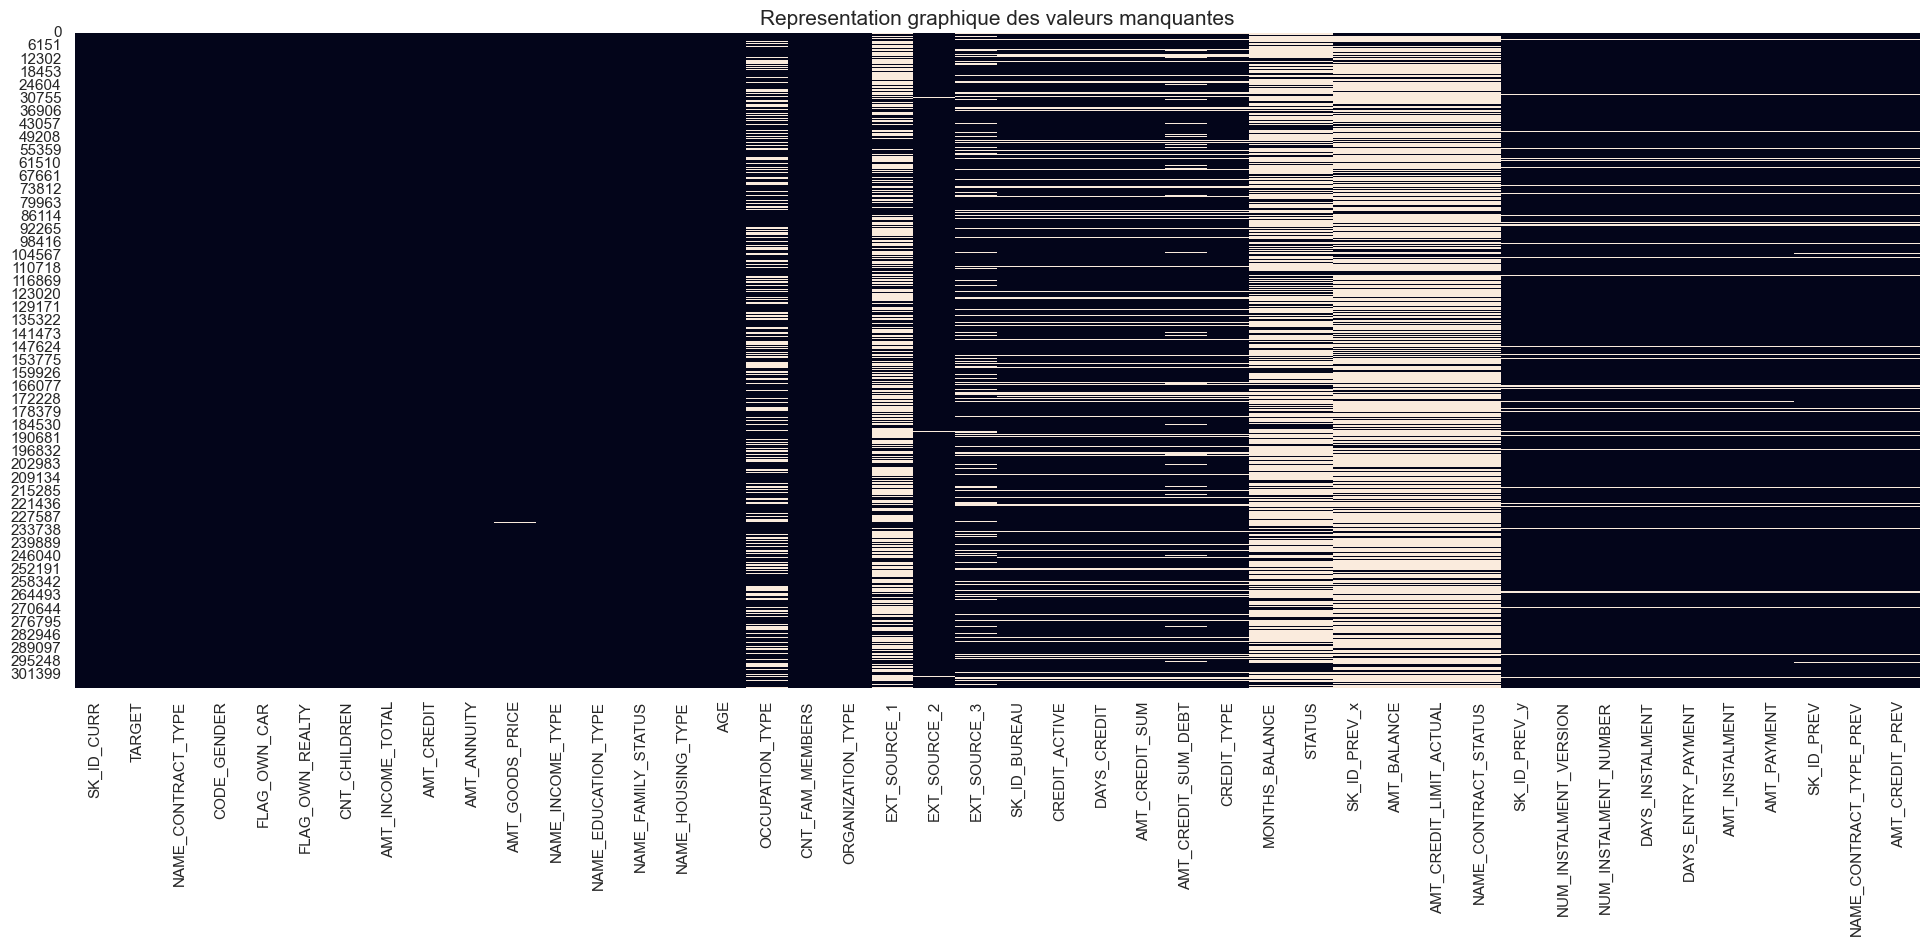

In [60]:
valeurs(data_final)

# Traitement des valeurs

On supprime les colonnes ayant plus de 70 % de Nan

In [61]:
columns_to_drop = ['NAME_CONTRACT_STATUS', 'NAME_CONTRACT_STATUS', 'SK_ID_PREV_x', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL', 'MONTHS_BALANCE', 'STATUS']
data_final = data_final.drop(columns=columns_to_drop)

On supprime les colonnes avec les identifiants des tables

In [62]:
columns_to_drop = ['SK_ID_BUREAU', 'SK_ID_PREV_y', 'SK_ID_PREV']
data_final = data_final.drop(columns=columns_to_drop)

Nous regardons aussi le nombre de valeurs inf dans les features 

In [63]:
import pandas as pd
import numpy as np

# Trouver les colonnes contenant la valeur "inf"
inf_columns = data_final.columns[data_final.isin([np.inf]).any()]

# Créer une liste pour stocker les informations
info_list = []

# Parcourir les colonnes et collecter les informations
for column in inf_columns:
    inf_values = data_final[column][data_final[column] == np.inf]
    inf_count = inf_values.shape[0]  # Nombre total d'occurrences de "inf" dans la colonne
    inf_percentage = (inf_count / len(data_final[column])) * 100  # Calcul du pourcentage d'occurrences
    inf_value_counts = inf_values.value_counts()  # Compter les occurrences de chaque valeur "inf"
    
    # Ajouter les informations à la liste
    info_list.append({'Colonne': column,
                      'Occurrences Inf': inf_count,
                      'Pourcentage Inf': inf_percentage,
                      'Comptage Inf': inf_value_counts})

# Créer un DataFrame à partir de la liste d'informations
info_df = pd.DataFrame(info_list)

# Afficher le DataFrame
info_df


,Colonne,Occurrences Inf,Pourcentage Inf,Comptage Inf
0,AMT_INCOME_TOTAL,297444,96.72630,"AMT_INCOME_TOTAL inf 297444 Name: count, dt..."
1,AMT_CREDIT,305819,99.44978,"AMT_CREDIT inf 305819 Name: count, dtype: i..."
2,AMT_ANNUITY,5359,1.74270,"AMT_ANNUITY inf 5359 Name: count, dtype: int64"
3,AMT_GOODS_PRICE,305173,99.23970,"AMT_GOODS_PRICE inf 305173 Name: count, dty..."
4,AMT_CREDIT_SUM,173391,56.38530,"AMT_CREDIT_SUM inf 173391 Name: count, dtyp..."
5,AMT_CREDIT_SUM_DEBT,40634,13.21384,"AMT_CREDIT_SUM_DEBT inf 40634 Name: count, ..."
6,AMT_CREDIT_PREV,164904,53.62540,"AMT_CREDIT_PREV inf 164904 Name: count, dty..."


On supprime les colonnes avec plus de 90 % de inf

In [64]:
columns_to_drop = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_GOODS_PRICE']
data_final = data_final.drop(columns=columns_to_drop)

Nous remplaçons les inf par 0

In [65]:
# Remplacer "inf" par 0 dans tout le DataFrame
data_final = data_final.replace(np.inf, 0)

In [66]:
missing_value_counts = data_final.isnull().sum()
print(missing_value_counts)

SK_ID_CURR                      0
TARGET                          0
NAME_CONTRACT_TYPE              0
CODE_GENDER                     0
FLAG_OWN_CAR                    0
FLAG_OWN_REALTY                 0
CNT_CHILDREN                    0
AMT_ANNUITY                    12
NAME_INCOME_TYPE                0
NAME_EDUCATION_TYPE             0
NAME_FAMILY_STATUS              0
NAME_HOUSING_TYPE               0
AGE                             0
OCCUPATION_TYPE             96391
CNT_FAM_MEMBERS                 2
ORGANIZATION_TYPE               0
EXT_SOURCE_1               173378
EXT_SOURCE_2                  660
EXT_SOURCE_3                60965
CREDIT_ACTIVE               44020
DAYS_CREDIT                 44020
AMT_CREDIT_SUM              44021
AMT_CREDIT_SUM_DEBT         51380
CREDIT_TYPE                 44020
NUM_INSTALMENT_VERSION      15868
NUM_INSTALMENT_NUMBER       15868
DAYS_INSTALMENT             15868
DAYS_ENTRY_PAYMENT          15876
AMT_INSTALMENT              15868
AMT_PAYMENT   

On s'occupe des Nan. Nous les remplacerons par 0. Nous exclurons la feature TARGET par précaution. 

In [67]:
data_final = data_final.fillna(0)

In [68]:
import pandas as pd

# Exclure la colonne cible
data_final_without_target = data_final.drop('TARGET', axis=1)

# Calculer le nombre de valeurs manquantes dans chaque colonne
missing_value_counts = data_final_without_target.isnull().sum()

# Afficher les résultats
print(missing_value_counts)



SK_ID_CURR                 0
NAME_CONTRACT_TYPE         0
CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
CNT_CHILDREN               0
AMT_ANNUITY                0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
AGE                        0
OCCUPATION_TYPE            0
CNT_FAM_MEMBERS            0
ORGANIZATION_TYPE          0
EXT_SOURCE_1               0
EXT_SOURCE_2               0
EXT_SOURCE_3               0
CREDIT_ACTIVE              0
DAYS_CREDIT                0
AMT_CREDIT_SUM             0
AMT_CREDIT_SUM_DEBT        0
CREDIT_TYPE                0
NUM_INSTALMENT_VERSION     0
NUM_INSTALMENT_NUMBER      0
DAYS_INSTALMENT            0
DAYS_ENTRY_PAYMENT         0
AMT_INSTALMENT             0
AMT_PAYMENT                0
NAME_CONTRACT_TYPE_PREV    0
AMT_CREDIT_PREV            0
dtype: int64


In [69]:
view_data_final = data_final.head(100).T
print(data_final.shape)
print(tabulate(view_data_final))

(307511, 32)
-----------------------  -----------------------------  -----------------  -----------------------------  -----------------------------  -----------------------------  -----------------------------  ----------------------  -----------------  -----------------------------  -----------------------------  -----------------  -----------------------------  -----------------------------  -----------------------------  -----------------------------  -----------------------------  -----------------------------  -----------------------------  -----------------------------  --------------------  -----------------------------  -----------------------------  -----------------------------  -----------------------------  -----------------------------  -----------------------------  -----------------------------  -----------------------------  --------------------  ----------------------  -----------------------------  -----------------------------  -----------------------------  -------

# Traitement des outliers

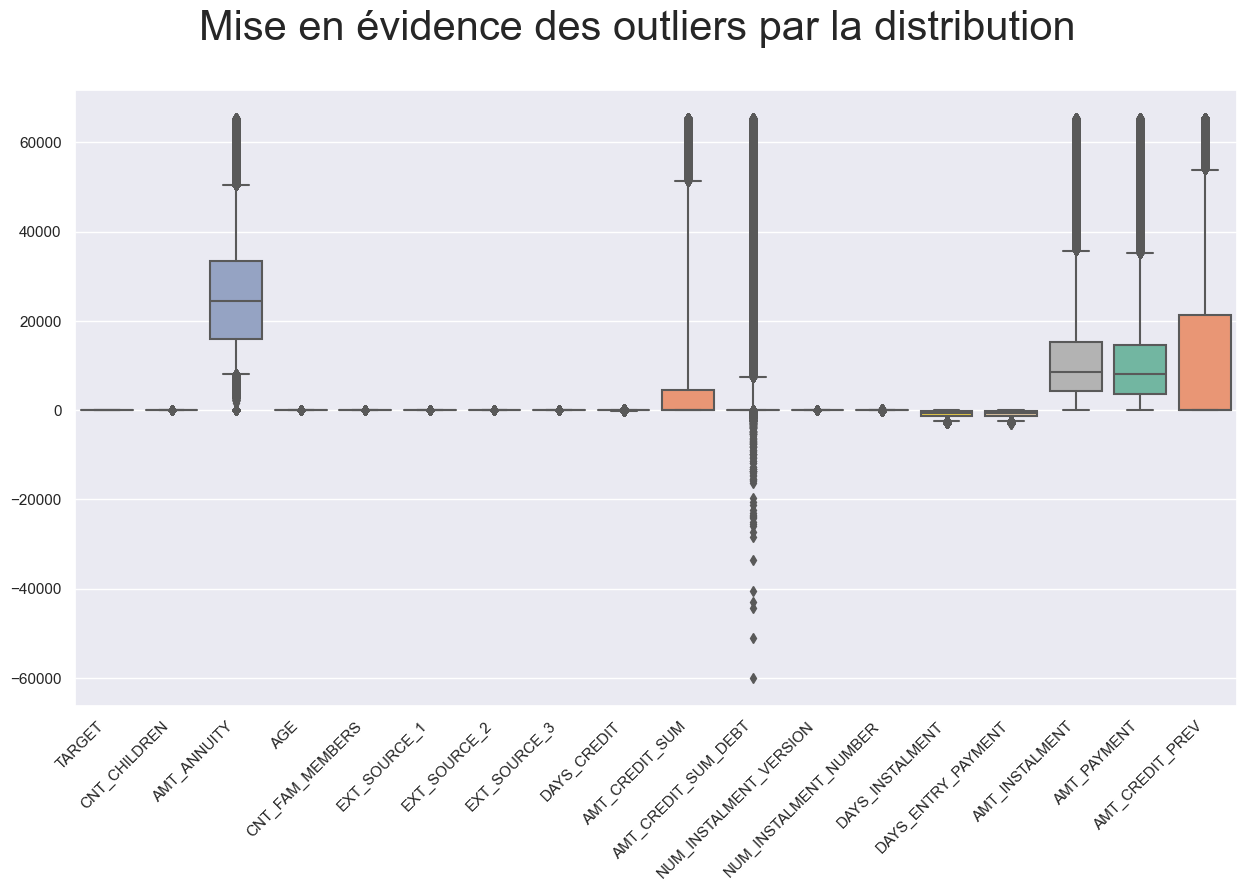

In [70]:
# Exclusion des colonnes 'SK_ID_CURR' et 'TARGET'
data_final_filtered = data_final.drop(columns=['SK_ID_CURR'])

# Mise en évidence des outliers par la distribution
fig, ax = plt.subplots(figsize=(15, 8))
fig.suptitle('Mise en évidence des outliers par la distribution', fontsize=30)

# Création du boxplot avec les percentiles 5 et 95
chart = sns.boxplot(data=data_final_filtered, palette='Set2', whis=[5, 95])

chart.set_xticklabels(chart.get_xticklabels(),
                      rotation=45,
                      horizontalalignment='right',
                      fontweight='light')

plt.show()

In [71]:
data_final_filtered.describe().T

,count,mean,std,min,25%,50%,75%,max
TARGET,307511.0,8.07288e-02,0.27242,0.0,0.00000,0.00000,0.00000,1.00000
CNT_CHILDREN,307511.0,4.17052e-01,0.72212,0.0,0.00000,0.00000,1.00000,19.00000
AMT_ANNUITY,307511.0,2.57308e+04,12931.39087,0.0,16024.00000,24368.00000,33472.00000,65504.00000
AGE,307511.0,4.39386e+01,11.96405,21.0,34.00000,43.00000,54.00000,69.00000
CNT_FAM_MEMBERS,307511.0,2.15265e+00,0.91070,0.0,2.00000,2.00000,3.00000,20.00000
EXT_SOURCE_1,307511.0,2.19023e-01,0.28537,0.0,0.00000,0.00000,0.45630,0.96289
EXT_SOURCE_2,307511.0,5.13289e-01,0.19233,0.0,0.39087,0.56543,0.66357,0.85498
EXT_SOURCE_3,307511.0,4.09574e-01,0.26818,0.0,0.17871,0.45972,0.63623,0.89600
DAYS_CREDIT,307511.0,-2.29645e+00,68.39494,-128.0,-57.00000,0.00000,50.00000,127.00000
AMT_CREDIT_SUM,307511.0,9.20734e+03,17580.31584,0.0,0.00000,0.00000,4500.00000,65500.00000


In [72]:
# Exclusion des colonnes 'SK_ID_CURR'
data_final_filtered = data_final.drop(columns=['SK_ID_CURR'])

# Identifier les colonnes numériques
numeric_cols = data_final_filtered.select_dtypes(include=['float', 'int']).columns

# Identifier les lignes contenant les valeurs maximales pour les colonnes spécifiques
max_rows = data_final_filtered[numeric_cols].apply(lambda x: x == x.max(), axis=0)

# Sélectionner les lignes contenant les valeurs maximales pour les colonnes spécifiques
rows_with_max_values = data_final[max_rows.any(axis=1)]


## Passage des valeurs de la feature AMT_CREDIT_SUM_DEBT au positif

In [73]:
# Remplacer "inf" par 0 dans tout le DataFrame
data_final['AMT_CREDIT_SUM_DEBT'] = data_final['AMT_CREDIT_SUM_DEBT'].replace(np.inf, 0)

In [74]:
# Inverser les valeurs négatives de la colonne 'AMT_CREDIT_SUM_DEBT'
data_final['AMT_CREDIT_SUM_DEBT'] = data_final['AMT_CREDIT_SUM_DEBT'].apply(lambda x: -x if x < 0 else x)

data_final

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_ANNUITY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CREDIT_ACTIVE,DAYS_CREDIT,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,CREDIT_TYPE,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,NAME_CONTRACT_TYPE_PREV,AMT_CREDIT_PREV
0,100002,1,Cash loans,M,N,Y,0.0,24704.0,Working,Secondary / secondary special,Single / not married,House / apartment,26.0,Laborers,1.0,Business Entity Type 3,0.08301,0.26294,0.13940,Closed,-101.0,40770.0,0.0,Credit card,1.0,16.0,-115.0,-133.0,9250.0,9250.0,Consumer loans,0.0
1,100003,0,Cash loans,F,N,N,0.0,35712.0,State servant,Higher education,Married,House / apartment,46.0,Core staff,2.0,School,0.31128,0.62207,0.00000,Closed,-26.0,22240.0,0.0,Consumer credit,1.0,2.0,-686.0,-690.0,0.0,0.0,Cash loans,0.0
2,100004,0,Revolving loans,M,Y,Y,0.0,6752.0,Working,Secondary / secondary special,Single / not married,House / apartment,52.0,Laborers,1.0,Government,0.00000,0.55615,0.72949,Closed,-46.0,0.0,0.0,Consumer credit,1.0,2.0,-754.0,-763.0,5356.0,5356.0,Consumer loans,20110.0
3,100006,0,Cash loans,F,N,Y,0.0,29680.0,Working,Secondary / secondary special,Civil marriage,House / apartment,52.0,Laborers,2.0,Business Entity Type 3,0.00000,0.65039,0.00000,0,0.0,0.0,0.0,0,1.0,3.0,-221.0,-226.0,29020.0,29020.0,Cash loans,0.0
4,100007,0,Cash loans,M,N,Y,0.0,21872.0,Working,Secondary / secondary special,Single / not married,House / apartment,55.0,Core staff,1.0,Religion,0.00000,0.32275,0.00000,Closed,-125.0,0.0,0.0,Consumer credit,1.0,4.0,-2236.0,-2234.0,1834.0,1834.0,Cash loans,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0.0,27552.0,Working,Secondary / secondary special,Separated,With parents,26.0,Sales staff,1.0,Services,0.14563,0.68164,0.00000,0,0.0,0.0,0.0,0,1.0,6.0,-60.0,-101.0,6604.0,6604.0,Consumer loans,40450.0
307507,456252,0,Cash loans,F,N,Y,0.0,12000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,57.0,0,1.0,XNA,0.00000,0.11597,0.00000,0,0.0,0.0,0.0,0,1.0,6.0,-2316.0,-2328.0,10050.0,10050.0,Consumer loans,56830.0
307508,456253,0,Cash loans,F,N,Y,0.0,29984.0,Working,Higher education,Separated,House / apartment,41.0,Managers,1.0,School,0.74414,0.53564,0.21887,Closed,105.0,0.0,0.0,Consumer credit,1.0,4.0,-2722.0,-2744.0,3972.0,3972.0,Consumer loans,27310.0
307509,456254,1,Cash loans,F,N,Y,0.0,20208.0,Commercial associate,Secondary / secondary special,Married,House / apartment,33.0,Laborers,2.0,Business Entity Type 1,0.00000,0.51416,0.66113,Closed,-80.0,45000.0,0.0,Consumer credit,1.0,7.0,-67.0,-78.0,19070.0,19070.0,Consumer loans,0.0


In [75]:
# Afficher les lignes contenant les valeurs maximales pour la feature 'AMT_ANNUITY'
rows_with_max_amt_annuity = rows_with_max_values[rows_with_max_values['AMT_ANNUITY'] == rows_with_max_values['AMT_ANNUITY'].max()]
rows_with_max_amt_annuity

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_ANNUITY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CREDIT_ACTIVE,DAYS_CREDIT,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,CREDIT_TYPE,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,NAME_CONTRACT_TYPE_PREV,AMT_CREDIT_PREV
114425,232691,0,Cash loans,F,N,N,0.0,65504.0,Commercial associate,Secondary / secondary special,Single / not married,Municipal apartment,33.0,Waiters/barmen staff,1.0,Hotel,0.00000,0.08990,0.49194,Active,25.0,0.0,0.0,Credit card,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
140840,263298,0,Cash loans,F,Y,N,0.0,65504.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,46.0,0,2.0,Business Entity Type 3,0.64600,0.75049,0.24585,Closed,12.0,0.0,0.0,Car loan,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
146627,270009,0,Cash loans,M,Y,N,2.0,65504.0,Working,Higher education,Married,House / apartment,36.0,Managers,4.0,Business Entity Type 3,0.40308,0.50293,0.46143,Closed,-38.0,0.0,0.0,Mortgage,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
156248,281122,0,Cash loans,F,Y,Y,1.0,65504.0,Working,Higher education,Married,House / apartment,36.0,Managers,3.0,Business Entity Type 3,0.00000,0.50244,0.61279,Closed,127.0,0.0,0.0,Consumer credit,0.0,56.0,-1385.0,-1385.0,136.6,136.6,Consumer loans,0.0
211505,345096,0,Cash loans,F,Y,N,1.0,65504.0,Commercial associate,Higher education,Single / not married,House / apartment,46.0,Managers,2.0,Other,0.77832,0.64160,0.46143,Closed,-64.0,0.0,0.0,Car loan,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
216326,350656,0,Cash loans,M,Y,Y,0.0,65504.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,26.0,Drivers,1.0,Transport: type 3,0.19897,0.71582,0.00000,0,0.0,0.0,0.0,0,1.0,1.0,-444.0,-459.0,9864.0,9864.0,Consumer loans,0.0
236241,373639,0,Cash loans,M,Y,Y,0.0,65504.0,Working,Secondary / secondary special,Married,House / apartment,43.0,Managers,2.0,Business Entity Type 3,0.00000,0.74316,0.00000,Active,-112.0,0.0,-219.4,Credit card,1.0,4.0,-1339.0,-1378.0,24720.0,4600.0,Cash loans,0.0


In [76]:
# Trier le DataFrame par la colonne 'AMT_ANNUITY' en ordre décroissant
data_final_sorted = data_final.sort_values(by='AMT_ANNUITY', ascending=False)

# Sélectionner les 50 premières lignes
top_50_max_values = data_final_sorted.head(100)

# Compter le nombre de valeurs avec TARGET 0 et TARGET 1 dans les 50 premières lignes
target_counts = top_50_max_values['TARGET'].value_counts()

print(target_counts)


TARGET
0    98
1     2
Name: count, dtype: int64


In [77]:
# Afficher les lignes contenant les valeurs maximales pour la feature 'AMT_CREDIT_SUM'
rows_with_max_amt_credit_sum = rows_with_max_values[rows_with_max_values['AMT_CREDIT_SUM'] == rows_with_max_values['AMT_CREDIT_SUM'].max()]
rows_with_max_amt_credit_sum

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_ANNUITY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CREDIT_ACTIVE,DAYS_CREDIT,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,CREDIT_TYPE,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,NAME_CONTRACT_TYPE_PREV,AMT_CREDIT_PREV
92,100110,0,Cash loans,M,Y,Y,3.0,25072.0,Commercial associate,Secondary / secondary special,Married,House / apartment,29.0,Laborers,5.0,Housing,0.00000,0.64062,0.32812,Active,-86.0,65500.0,52830.0,Consumer credit,1.0,5.0,-8.0,-28.0,10430.0,10430.00,Consumer loans,40030.0
5335,106238,0,Cash loans,F,N,Y,1.0,10784.0,Working,Higher education,Married,Co-op apartment,30.0,High skill tech staff,3.0,Self-employed,0.67139,0.69922,0.42407,Closed,16.0,65500.0,0.0,Consumer credit,1.0,4.0,-644.0,-676.0,6124.0,6124.00,Consumer loans,0.0
16348,119067,0,Revolving loans,M,Y,Y,2.0,7876.0,Working,Secondary / secondary special,Married,House / apartment,36.0,Managers,4.0,Business Entity Type 3,0.00000,0.61426,0.56396,Closed,115.0,65500.0,0.0,Consumer credit,1.0,8.0,-280.0,-318.0,6140.0,6140.00,Cash loans,0.0
31069,136063,0,Cash loans,F,Y,N,2.0,28720.0,Commercial associate,Higher education,Civil marriage,House / apartment,38.0,Accountants,4.0,Other,0.60938,0.64209,0.62793,Closed,-121.0,65500.0,0.0,Consumer credit,1.0,4.0,-1725.0,-1759.0,6456.0,6456.00,Consumer loans,54980.0
34474,139947,0,Cash loans,M,Y,N,1.0,21888.0,Working,Secondary / secondary special,Married,House / apartment,32.0,High skill tech staff,3.0,Other,0.00000,0.51709,0.73779,Closed,52.0,65500.0,0.0,Consumer credit,1.0,19.0,-2900.0,-2984.0,1576.0,1576.00,0,0.0
42466,149151,0,Cash loans,F,N,N,0.0,20160.0,Pensioner,Secondary / secondary special,Widow,House / apartment,60.0,0,1.0,XNA,0.74561,0.58691,0.61279,Closed,-46.0,65500.0,0.0,Consumer credit,1.0,6.0,-2332.0,-2374.0,13976.0,13976.00,Consumer loans,0.0
96008,211464,0,Revolving loans,M,Y,N,2.0,9000.0,Working,Incomplete higher,Single / not married,Rented apartment,27.0,Laborers,3.0,Industry: type 9,0.00000,0.41382,0.58301,Closed,-103.0,65500.0,0.0,Consumer credit,0.0,2.0,-469.0,-471.0,2250.0,2250.00,Consumer loans,24510.0
106251,223276,0,Cash loans,F,N,Y,0.0,47808.0,Pensioner,Incomplete higher,Married,House / apartment,61.0,0,2.0,XNA,0.61865,0.69336,0.78613,Closed,-93.0,65500.0,0.0,Consumer credit,0.0,24.0,-2484.0,-2484.0,2856.0,2856.00,Cash loans,0.0
106437,223478,0,Cash loans,M,N,Y,0.0,30528.0,Commercial associate,Secondary / secondary special,Separated,House / apartment,46.0,Laborers,1.0,Self-employed,0.00000,0.61523,0.48120,Closed,53.0,65500.0,0.0,Consumer credit,1.0,3.0,-2836.0,-2836.0,3776.0,3776.00,0,0.0
110615,228319,0,Cash loans,M,Y,N,0.0,26576.0,Working,Secondary / secondary special,Married,House / apartment,50.0,Drivers,2.0,Agriculture,0.00000,0.62646,0.44897,Active,-103.0,65500.0,14040.0,Consumer credit,1.0,3.0,-2368.0,-2384.0,2406.0,2406.00,Consumer loans,28750.0


In [78]:
# Trier le DataFrame par la colonne 'AMT_ANNUITY' en ordre décroissant
data_final_sorted = data_final.sort_values(by='AMT_CREDIT_SUM', ascending=False)

# Sélectionner les 50 premières lignes
top_50_max_values = data_final_sorted.head(100)

# Compter le nombre de valeurs avec TARGET 0 et TARGET 1 dans les 50 premières lignes
target_counts = top_50_max_values['TARGET'].value_counts()

print(target_counts)


TARGET
0    90
1    10
Name: count, dtype: int64


In [79]:
# Afficher les lignes contenant les valeurs maximales pour la feature 'AMT_INSTALMENT'
rows_with_max_amt_installment = rows_with_max_values[rows_with_max_values['AMT_INSTALMENT'] == rows_with_max_values['AMT_INSTALMENT'].max()]
rows_with_max_amt_installment

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_ANNUITY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CREDIT_ACTIVE,DAYS_CREDIT,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,CREDIT_TYPE,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,NAME_CONTRACT_TYPE_PREV,AMT_CREDIT_PREV
59189,168604,0,Revolving loans,F,N,Y,0.0,20256.0,Commercial associate,Secondary / secondary special,Married,House / apartment,59.0,Accountants,2.0,Business Entity Type 3,0.00000,0.15967,0.00000,0,0.0,0.0,0.0,0,1.0,2.0,-684.0,-692.0,65500.0,65500.0,Consumer loans,21020.0
90324,204867,0,Cash loans,M,Y,Y,0.0,40704.0,Commercial associate,Secondary / secondary special,Married,House / apartment,52.0,Managers,2.0,Business Entity Type 3,0.73633,0.58350,0.57812,Closed,88.0,0.0,0.0,Consumer credit,1.0,18.0,-449.0,-449.0,65500.0,65500.0,Cash loans,0.0
102434,218915,1,Cash loans,M,N,Y,1.0,19744.0,Working,Secondary / secondary special,Civil marriage,House / apartment,27.0,Laborers,3.0,Construction,0.00000,0.50586,0.00000,0,0.0,0.0,0.0,0,0.0,7.0,-174.0,-174.0,65500.0,65500.0,Cash loans,0.0
104328,221082,0,Cash loans,M,Y,Y,0.0,45440.0,Commercial associate,Higher education,Married,House / apartment,42.0,High skill tech staff,2.0,Business Entity Type 3,0.00000,0.70898,0.14282,Closed,-47.0,0.0,0.0,Car loan,1.0,9.0,-306.0,-306.0,65500.0,65500.0,Consumer loans,0.0
233417,370363,0,Cash loans,M,Y,N,1.0,12224.0,Working,Secondary / secondary special,Married,House / apartment,47.0,0,3.0,Industry: type 9,0.00000,0.65039,0.48120,Active,-32.0,0.0,0.0,Consumer credit,2.0,4.0,-1255.0,-1265.0,65500.0,65500.0,Cash loans,0.0
236702,374170,0,Cash loans,M,N,N,0.0,37728.0,Working,Secondary / secondary special,Single / not married,House / apartment,28.0,Laborers,1.0,Business Entity Type 3,0.23108,0.53857,0.00000,0,0.0,0.0,0.0,0,1.0,8.0,-259.0,-273.0,65500.0,65500.0,Cash loans,0.0
271629,414897,0,Cash loans,F,Y,Y,0.0,32016.0,Working,Secondary / secondary special,Married,House / apartment,51.0,High skill tech staff,2.0,Self-employed,0.54150,0.67578,0.00000,0,0.0,0.0,0.0,0,2.0,8.0,-653.0,-656.0,65500.0,65500.0,Consumer loans,0.0


In [80]:
# Trier le DataFrame par la colonne 'AMT_ANNUITY' en ordre décroissant
data_final_sorted = data_final.sort_values(by='AMT_INSTALMENT', ascending=False)

# Sélectionner les 50 premières lignes
top_50_max_values = data_final_sorted.head(100)

# Compter le nombre de valeurs avec TARGET 0 et TARGET 1 dans les 50 premières lignes
target_counts = top_50_max_values['TARGET'].value_counts()

print(target_counts)

TARGET
0    92
1     8
Name: count, dtype: int64


In [81]:
# Afficher les lignes contenant les valeurs maximales pour la feature 'AMT_PAYMENT'
rows_with_max_amt_payment = rows_with_max_values[rows_with_max_values['AMT_PAYMENT'] == rows_with_max_values['AMT_PAYMENT'].max()]
rows_with_max_amt_payment

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_ANNUITY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CREDIT_ACTIVE,DAYS_CREDIT,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,CREDIT_TYPE,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,NAME_CONTRACT_TYPE_PREV,AMT_CREDIT_PREV
59189,168604,0,Revolving loans,F,N,Y,0.0,20256.0,Commercial associate,Secondary / secondary special,Married,House / apartment,59.0,Accountants,2.0,Business Entity Type 3,0.00000,0.15967,0.00000,0,0.0,0.0,0.0,0,1.0,2.0,-684.0,-692.0,65500.0,65500.0,Consumer loans,21020.0
90324,204867,0,Cash loans,M,Y,Y,0.0,40704.0,Commercial associate,Secondary / secondary special,Married,House / apartment,52.0,Managers,2.0,Business Entity Type 3,0.73633,0.58350,0.57812,Closed,88.0,0.0,0.0,Consumer credit,1.0,18.0,-449.0,-449.0,65500.0,65500.0,Cash loans,0.0
102434,218915,1,Cash loans,M,N,Y,1.0,19744.0,Working,Secondary / secondary special,Civil marriage,House / apartment,27.0,Laborers,3.0,Construction,0.00000,0.50586,0.00000,0,0.0,0.0,0.0,0,0.0,7.0,-174.0,-174.0,65500.0,65500.0,Cash loans,0.0
104328,221082,0,Cash loans,M,Y,Y,0.0,45440.0,Commercial associate,Higher education,Married,House / apartment,42.0,High skill tech staff,2.0,Business Entity Type 3,0.00000,0.70898,0.14282,Closed,-47.0,0.0,0.0,Car loan,1.0,9.0,-306.0,-306.0,65500.0,65500.0,Consumer loans,0.0
233417,370363,0,Cash loans,M,Y,N,1.0,12224.0,Working,Secondary / secondary special,Married,House / apartment,47.0,0,3.0,Industry: type 9,0.00000,0.65039,0.48120,Active,-32.0,0.0,0.0,Consumer credit,2.0,4.0,-1255.0,-1265.0,65500.0,65500.0,Cash loans,0.0
236702,374170,0,Cash loans,M,N,N,0.0,37728.0,Working,Secondary / secondary special,Single / not married,House / apartment,28.0,Laborers,1.0,Business Entity Type 3,0.23108,0.53857,0.00000,0,0.0,0.0,0.0,0,1.0,8.0,-259.0,-273.0,65500.0,65500.0,Cash loans,0.0
260438,401393,0,Cash loans,F,Y,Y,1.0,27520.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,32.0,Laborers,3.0,Business Entity Type 3,0.43384,0.37280,0.80615,Closed,105.0,21150.0,0.0,Consumer credit,1.0,3.0,-47.0,-50.0,3698.0,65500.0,Consumer loans,25870.0
271629,414897,0,Cash loans,F,Y,Y,0.0,32016.0,Working,Secondary / secondary special,Married,House / apartment,51.0,High skill tech staff,2.0,Self-employed,0.54150,0.67578,0.00000,0,0.0,0.0,0.0,0,2.0,8.0,-653.0,-656.0,65500.0,65500.0,Consumer loans,0.0


In [82]:
# Trier le DataFrame par la colonne 'AMT_ANNUITY' en ordre décroissant
data_final_sorted = data_final.sort_values(by='AMT_PAYMENT', ascending=False)

# Sélectionner les 50 premières lignes
top_50_max_values = data_final_sorted.head(100)

# Compter le nombre de valeurs avec TARGET 0 et TARGET 1 dans les 50 premières lignes
target_counts = top_50_max_values['TARGET'].value_counts()

print(target_counts)

TARGET
0    91
1     9
Name: count, dtype: int64


In [83]:
# Afficher les lignes contenant les valeurs maximales pour la feature 'AMT_CREDIT_PREV'
rows_with_max_amt_credit_prev = rows_with_max_values[rows_with_max_values['AMT_CREDIT_PREV'] == rows_with_max_values['AMT_CREDIT_PREV'].max()]
rows_with_max_amt_credit_prev.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_ANNUITY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CREDIT_ACTIVE,DAYS_CREDIT,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,CREDIT_TYPE,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,NAME_CONTRACT_TYPE_PREV,AMT_CREDIT_PREV
6481,107560,0,Cash loans,F,N,Y,0.0,27088.0,Commercial associate,Incomplete higher,Single / not married,With parents,22.0,Laborers,1.0,Other,0.76172,0.65527,0.66895,Closed,-40.0,0.0,0.0,Consumer credit,1.0,4.0,-166.0,-178.0,7440.0,7440.0,Consumer loans,65500.0
12696,114799,0,Cash loans,F,N,N,0.0,0.0,Working,Higher education,Married,House / apartment,29.0,Sales staff,2.0,Self-employed,0.10358,0.64453,0.07648,Closed,-2.0,0.0,0.0,Consumer credit,1.0,10.0,-273.0,-275.0,0.0,0.0,Consumer loans,65500.0
14785,117259,0,Cash loans,F,N,N,0.0,28496.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,43.0,Sales staff,2.0,Trade: type 7,0.45801,0.53369,0.64795,Closed,-76.0,0.0,0.0,Consumer credit,1.0,13.0,-325.0,-327.0,4130.0,4130.0,Cash loans,65500.0
25863,130072,0,Cash loans,M,Y,N,0.0,17840.0,Working,Secondary / secondary special,Single / not married,With parents,22.0,Sales staff,1.0,Trade: type 2,0.37915,0.49829,0.00000,0,0.0,0.0,0.0,0,1.0,1.0,-121.0,-140.0,6132.0,6132.0,Consumer loans,65500.0
36060,141770,0,Cash loans,M,Y,N,0.0,33024.0,Commercial associate,Secondary / secondary special,Married,House / apartment,46.0,Laborers,2.0,Business Entity Type 3,0.00000,0.37769,0.71680,Closed,-114.0,64540.0,0.0,Consumer credit,1.0,4.0,-1813.0,-1839.0,2828.0,2828.0,Consumer loans,65500.0


In [84]:
# Trier le DataFrame par la colonne 'AMT_ANNUITY' en ordre décroissant
data_final_sorted = data_final.sort_values(by='AMT_CREDIT_PREV', ascending=False)

# Sélectionner les 50 premières lignes
top_50_max_values = data_final_sorted.head(100)

# Compter le nombre de valeurs avec TARGET 0 et TARGET 1 dans les 50 premières lignes
target_counts = top_50_max_values['TARGET'].value_counts()

print(target_counts)

TARGET
0    94
1     6
Name: count, dtype: int64


# Tri de feature

In [85]:
# Création de la liste de colonnes à supprimer  
list = ['NUM_INSTALMENT_VERSION', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT', 'DAYS_CREDIT', 'AMT_CREDIT_SUM_DEBT']
#On supprime ensuite cette liste du dataset data_final
data_final.drop(list, axis=1, inplace=True)

# Modification de valeurs 

## Feature NAME_EDUCATION_TYPE

In [86]:
# Remplacer les '/' et les espaces ' ' par des underscores '_' dans la feature 'NAME_EDUCATION_TYPE'
data_final['NAME_EDUCATION_TYPE'] = data_final['NAME_EDUCATION_TYPE'].str.replace('/', '_').str.replace(' ', '_')
data_final['NAME_EDUCATION_TYPE'] = data_final['NAME_EDUCATION_TYPE'].str.replace('__', '_')
print(data_final['NAME_EDUCATION_TYPE'])

0         Secondary__secondary_special
1                     Higher_education
2         Secondary__secondary_special
3         Secondary__secondary_special
4         Secondary__secondary_special
                      ...             
307506    Secondary__secondary_special
307507    Secondary__secondary_special
307508                Higher_education
307509    Secondary__secondary_special
307510                Higher_education
Name: NAME_EDUCATION_TYPE, Length: 307511, dtype: object


## Feature NAME_FAMILY_STATUS 

In [87]:
# Remplacer les '/' et les espaces ' ' par des underscores '_' dans la feature 'NAME_FAMILY_STATUS'
data_final['NAME_FAMILY_STATUS'] = data_final['NAME_FAMILY_STATUS'].str.replace('/', '_').str.replace(' ', '_').str.replace('__', '_')
data_final['NAME_FAMILY_STATUS'] = data_final['NAME_FAMILY_STATUS'].str.replace('__', '_')
print(data_final['NAME_FAMILY_STATUS'])

0         Single_not_married
1                    Married
2         Single_not_married
3             Civil_marriage
4         Single_not_married
                 ...        
307506             Separated
307507                 Widow
307508             Separated
307509               Married
307510               Married
Name: NAME_FAMILY_STATUS, Length: 307511, dtype: object


## Feature NAME_HOUSING_TYPE 

In [88]:
# Remplacer les '/' et les espaces ' ' par des underscores '_' dans la feature 'NAME_HOUSING_TYPE'
data_final['NAME_HOUSING_TYPE'] = data_final['NAME_HOUSING_TYPE'].str.replace('/', '_').str.replace(' ', '_').str.replace('__', '_')
data_final['NAME_HOUSING_TYPE'] = data_final['NAME_HOUSING_TYPE'].str.replace('__', '_')
print(data_final['NAME_HOUSING_TYPE'])

0         House_apartment
1         House_apartment
2         House_apartment
3         House_apartment
4         House_apartment
               ...       
307506       With_parents
307507    House_apartment
307508    House_apartment
307509    House_apartment
307510    House_apartment
Name: NAME_HOUSING_TYPE, Length: 307511, dtype: object


## Feature ORGANIZATION_TYPE

In [89]:
# Remplacer les '/' et les espaces ' ' par des underscores '_' dans la feature 'NAME_HOUSING_TYPE'
data_final['ORGANIZATION_TYPE'] = data_final['ORGANIZATION_TYPE'].str.replace('/', '_').str.replace(' ', '_').str.replace('__', '_')
data_final['ORGANIZATION_TYPE'] = data_final['ORGANIZATION_TYPE'].str.replace('__', '_')
print(data_final['ORGANIZATION_TYPE'])

0         Business_Entity_Type_3
1                         School
2                     Government
3         Business_Entity_Type_3
4                       Religion
                   ...          
307506                  Services
307507                       XNA
307508                    School
307509    Business_Entity_Type_1
307510    Business_Entity_Type_3
Name: ORGANIZATION_TYPE, Length: 307511, dtype: object


## Feature NAME_CONTRACT_TYPE

In [90]:
# Remplacer les '/' et les espaces ' ' par des underscores '_' dans la feature 'NAME_HOUSING_TYPE'
data_final['NAME_CONTRACT_TYPE'] = data_final['NAME_CONTRACT_TYPE'].str.replace('/', '_').str.replace(' ', '_').str.replace('__', '_')
data_final['NAME_CONTRACT_TYPE'] = data_final['NAME_CONTRACT_TYPE'].str.replace('__', '_')
print(data_final['NAME_CONTRACT_TYPE'])

0              Cash_loans
1              Cash_loans
2         Revolving_loans
3              Cash_loans
4              Cash_loans
               ...       
307506         Cash_loans
307507         Cash_loans
307508         Cash_loans
307509         Cash_loans
307510         Cash_loans
Name: NAME_CONTRACT_TYPE, Length: 307511, dtype: object


## Feature CREDIT_TYPE

In [91]:
# Remplacer les '/' et les espaces ' ' par des underscores '_' dans la feature 'NAME_HOUSING_TYPE'
data_final['CREDIT_TYPE'] = data_final['CREDIT_TYPE'].str.replace('/', '_').str.replace(' ', '_').str.replace('__', '_')
data_final['CREDIT_TYPE'] = data_final['CREDIT_TYPE'].str.replace('__', '_')
print(data_final['CREDIT_TYPE'])

0             Credit_card
1         Consumer_credit
2         Consumer_credit
3                     NaN
4         Consumer_credit
               ...       
307506                NaN
307507                NaN
307508    Consumer_credit
307509    Consumer_credit
307510    Consumer_credit
Name: CREDIT_TYPE, Length: 307511, dtype: object


## Feature NAME_CONTRACT_TYPE_PREV

In [92]:
# Remplacer les '/' et les espaces ' ' par des underscores '_' dans la feature 'NAME_HOUSING_TYPE'
data_final['NAME_CONTRACT_TYPE_PREV'] = data_final['NAME_CONTRACT_TYPE_PREV'].str.replace('/', '_').str.replace(' ', '_').str.replace('__', '_')
data_final['NAME_CONTRACT_TYPE_PREV'] = data_final['NAME_CONTRACT_TYPE_PREV'].str.replace('__', '_')
print(data_final['NAME_CONTRACT_TYPE_PREV'])

0         Consumer_loans
1             Cash_loans
2         Consumer_loans
3             Cash_loans
4             Cash_loans
               ...      
307506    Consumer_loans
307507    Consumer_loans
307508    Consumer_loans
307509    Consumer_loans
307510    Consumer_loans
Name: NAME_CONTRACT_TYPE_PREV, Length: 307511, dtype: object


## Feature NAME_INCOME_TYPE

In [93]:
data_final['NAME_INCOME_TYPE'] = data_final['NAME_INCOME_TYPE'].str.replace('/', '_').str.replace(' ', '_').str.replace('__', '_')
data_final['NAME_INCOME_TYPE'] = data_final['NAME_INCOME_TYPE'].str.replace('__', '_')
print(data_final['NAME_INCOME_TYPE'])

0                      Working
1                State_servant
2                      Working
3                      Working
4                      Working
                  ...         
307506                 Working
307507               Pensioner
307508                 Working
307509    Commercial_associate
307510    Commercial_associate
Name: NAME_INCOME_TYPE, Length: 307511, dtype: object


## Feature OCCUPATION_TYPE

In [94]:
data_final['OCCUPATION_TYPE'] = data_final['OCCUPATION_TYPE'].str.replace('/', '_').str.replace(' ', '_').str.replace('__', '_')
data_final['OCCUPATION_TYPE'] = data_final['OCCUPATION_TYPE'].str.replace('__', '_')
print(data_final['OCCUPATION_TYPE'])

0            Laborers
1          Core_staff
2            Laborers
3            Laborers
4          Core_staff
             ...     
307506    Sales_staff
307507            NaN
307508       Managers
307509       Laborers
307510       Laborers
Name: OCCUPATION_TYPE, Length: 307511, dtype: object


## Feature CREDIT ACTIVE 

In [95]:
value_counts = data_final['CREDIT_ACTIVE'].value_counts()
print(value_counts)


CREDIT_ACTIVE
Closed      178030
Active       84700
0            44020
Sold           758
Bad debt         3
Name: count, dtype: int64


In [96]:
# Définir le mapping
mapping = {'Closed': 0, 'Active': 1, 'Sold': 0}

# Remplacer les valeurs en utilisant le mapping
data_final['CREDIT_ACTIVE'] = data_final['CREDIT_ACTIVE'].replace(mapping)

# Supprimer les lignes où 'CREDIT_ACTIVE' est 'Bad Debt'
data_final = data_final[data_final['CREDIT_ACTIVE'] != 'Bad debt']

# Convertir la colonne en int (cela supposera que toutes les valeurs restantes sont numériques)
data_final['CREDIT_ACTIVE'] = data_final['CREDIT_ACTIVE'].astype(int)

Les valeurs maximales ne semblent pas êtres des outliers. 

In [97]:
view_data_final = data_final.head(10).T
print(data_final.shape)
print(tabulate(view_data_final))

(307508, 27)
-----------------------  ----------------------------  ----------------  ----------------------------  ----------------------------  ----------------------------  ----------------------------  ----------------------  ----------------  ----------------------------  ----------------------------
SK_ID_CURR               100002                        100003            100004                        100006                        100007                        100008                        100009                  100010            100011                        100012
TARGET                   1                             0                 0                             0                             0                             0                             0                       0                 0                             0
NAME_CONTRACT_TYPE       Cash_loans                    Cash_loans        Revolving_loans               Cash_loans                    Cash_loans           

In [98]:
data_final.dtypes

SK_ID_CURR                   int64
TARGET                       int64
NAME_CONTRACT_TYPE          object
CODE_GENDER                 object
FLAG_OWN_CAR                object
FLAG_OWN_REALTY             object
CNT_CHILDREN               float64
AMT_ANNUITY                float64
NAME_INCOME_TYPE            object
NAME_EDUCATION_TYPE         object
NAME_FAMILY_STATUS          object
NAME_HOUSING_TYPE           object
AGE                        float64
OCCUPATION_TYPE             object
CNT_FAM_MEMBERS            float64
ORGANIZATION_TYPE           object
EXT_SOURCE_1               float64
EXT_SOURCE_2               float64
EXT_SOURCE_3               float64
CREDIT_ACTIVE                int64
AMT_CREDIT_SUM             float64
CREDIT_TYPE                 object
NUM_INSTALMENT_NUMBER      float64
AMT_INSTALMENT             float64
AMT_PAYMENT                float64
NAME_CONTRACT_TYPE_PREV     object
AMT_CREDIT_PREV            float64
dtype: object

In [99]:
data_final.corr(numeric_only=True)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_ANNUITY,AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CREDIT_ACTIVE,AMT_CREDIT_SUM,NUM_INSTALMENT_NUMBER,AMT_INSTALMENT,AMT_PAYMENT,AMT_CREDIT_PREV
SK_ID_CURR,1.00000,-0.00210,-0.00113,0.00014,0.00148,-0.00288,-0.00035,0.00252,0.00033,0.00102,-0.00045,0.00171,0.00038,0.00179,-0.00192
TARGET,-0.00210,1.00000,0.01918,0.00465,-0.07826,0.00930,-0.06471,-0.15903,-0.11959,0.03082,-0.00163,-0.00212,-0.02466,-0.02933,0.00879
CNT_CHILDREN,-0.00113,0.01918,1.00000,0.02316,-0.33081,0.87915,0.05121,-0.01790,-0.00978,0.00935,0.02456,-0.00914,-0.02230,-0.02293,0.04581
AMT_ANNUITY,0.00014,0.00465,0.02316,1.00000,-0.01525,0.07384,0.06833,0.09548,0.02107,0.00193,-0.04500,0.03198,0.11395,0.10608,-0.05652
AGE,0.00148,-0.07826,-0.33081,-0.01525,1.00000,-0.27873,-0.05910,0.09048,0.15123,-0.06365,-0.02560,0.04684,0.06533,0.06454,-0.07631
CNT_FAM_MEMBERS,-0.00288,0.00930,0.87915,0.07384,-0.27873,1.00000,0.05097,-0.00172,0.00729,0.01122,0.01587,0.00289,-0.00326,-0.00478,0.02922
EXT_SOURCE_1,-0.00035,-0.06471,0.05121,0.06833,-0.05910,0.05097,1.00000,0.11408,0.04043,0.00486,0.00021,0.02185,0.01261,0.01283,-0.00694
EXT_SOURCE_2,0.00252,-0.15903,-0.01790,0.09548,0.09048,-0.00172,0.11408,1.00000,0.09666,-0.01302,-0.02179,0.01949,0.04340,0.04281,-0.03812
EXT_SOURCE_3,0.00033,-0.11959,-0.00978,0.02107,0.15123,0.00729,0.04043,0.09666,1.00000,0.02397,0.14002,0.01538,0.00472,0.01076,0.00761
CREDIT_ACTIVE,0.00102,0.03082,0.00935,0.00193,-0.06365,0.01122,0.00486,-0.01302,0.02397,1.00000,-0.15078,0.00176,-0.01198,-0.01364,-0.01217


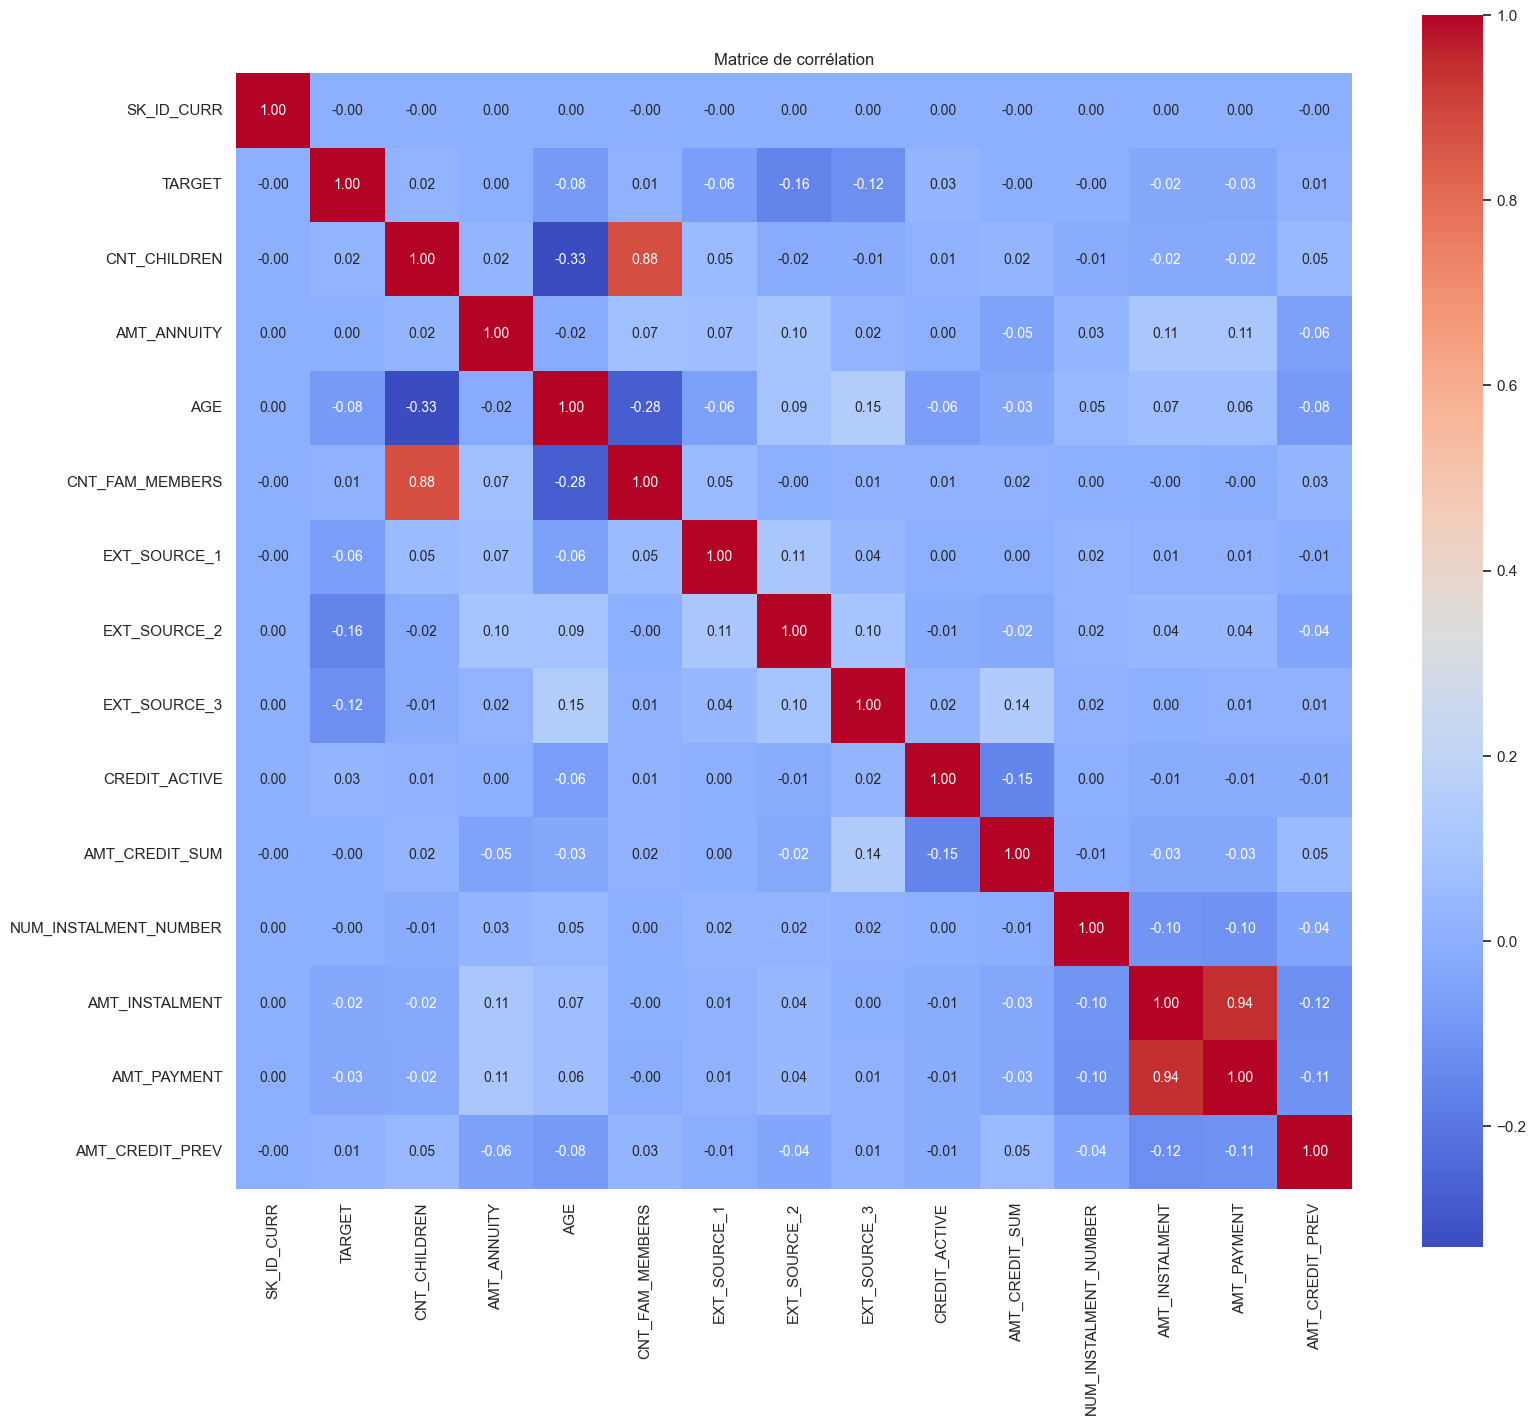

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcul de la matrice de corrélation
correlation_matrix = data_final.corr(numeric_only=True)

# Affichage de la matrice de corrélation avec heatmap
plt.figure(figsize=(18, 16))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, annot_kws={"size": 10})
plt.title("Matrice de corrélation")
plt.show()


## Contrôle des NaN     

In [101]:
missing_value_counts = data_final.isna().sum()
print(missing_value_counts)

SK_ID_CURR                     0
TARGET                         0
NAME_CONTRACT_TYPE             0
CODE_GENDER                    0
FLAG_OWN_CAR                   0
FLAG_OWN_REALTY                0
CNT_CHILDREN                   0
AMT_ANNUITY                    0
NAME_INCOME_TYPE               0
NAME_EDUCATION_TYPE            0
NAME_FAMILY_STATUS             0
NAME_HOUSING_TYPE              0
AGE                            0
OCCUPATION_TYPE            96389
CNT_FAM_MEMBERS                0
ORGANIZATION_TYPE              0
EXT_SOURCE_1                   0
EXT_SOURCE_2                   0
EXT_SOURCE_3                   0
CREDIT_ACTIVE                  0
AMT_CREDIT_SUM                 0
CREDIT_TYPE                44020
NUM_INSTALMENT_NUMBER          0
AMT_INSTALMENT                 0
AMT_PAYMENT                    0
NAME_CONTRACT_TYPE_PREV    16454
AMT_CREDIT_PREV                0
dtype: int64


In [102]:
# Nous remplacons les Nan par autre
data_final = data_final.fillna('autre')


In [103]:
missing_value_counts = data_final.isna().sum()
print(missing_value_counts)

SK_ID_CURR                 0
TARGET                     0
NAME_CONTRACT_TYPE         0
CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
CNT_CHILDREN               0
AMT_ANNUITY                0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
AGE                        0
OCCUPATION_TYPE            0
CNT_FAM_MEMBERS            0
ORGANIZATION_TYPE          0
EXT_SOURCE_1               0
EXT_SOURCE_2               0
EXT_SOURCE_3               0
CREDIT_ACTIVE              0
AMT_CREDIT_SUM             0
CREDIT_TYPE                0
NUM_INSTALMENT_NUMBER      0
AMT_INSTALMENT             0
AMT_PAYMENT                0
NAME_CONTRACT_TYPE_PREV    0
AMT_CREDIT_PREV            0
dtype: int64


In [104]:
view_data_final = data_final.head(10).T
print(data_final.shape)
print(tabulate(view_data_final))

(307508, 27)
-----------------------  ----------------------------  ----------------  ----------------------------  ----------------------------  ----------------------------  ----------------------------  ----------------------  ----------------  ----------------------------  ----------------------------
SK_ID_CURR               100002                        100003            100004                        100006                        100007                        100008                        100009                  100010            100011                        100012
TARGET                   1                             0                 0                             0                             0                             0                             0                       0                 0                             0
NAME_CONTRACT_TYPE       Cash_loans                    Cash_loans        Revolving_loans               Cash_loans                    Cash_loans           

## Contrôle de mémoire

In [105]:
# Contrôle de mémoire
total_memory = 0

original_memory = data_final.memory_usage().sum()
total_memory += original_memory
print(f'Original Memory Usage app_test: {round(original_memory / 1e9, 2)} gb.')
print()

Original Memory Usage app_test: 0.07 gb.



In [106]:
# Convertir la colonne 'SK_ID' en type 'object'
data_final['SK_ID_CURR'] = data_final['SK_ID_CURR'].astype('object')

# Afficher le DataFrame 'data_final' après la conversion
print(data_final.dtypes)

SK_ID_CURR                  object
TARGET                       int64
NAME_CONTRACT_TYPE          object
CODE_GENDER                 object
FLAG_OWN_CAR                object
FLAG_OWN_REALTY             object
CNT_CHILDREN               float64
AMT_ANNUITY                float64
NAME_INCOME_TYPE            object
NAME_EDUCATION_TYPE         object
NAME_FAMILY_STATUS          object
NAME_HOUSING_TYPE           object
AGE                        float64
OCCUPATION_TYPE             object
CNT_FAM_MEMBERS            float64
ORGANIZATION_TYPE           object
EXT_SOURCE_1               float64
EXT_SOURCE_2               float64
EXT_SOURCE_3               float64
CREDIT_ACTIVE                int64
AMT_CREDIT_SUM             float64
CREDIT_TYPE                 object
NUM_INSTALMENT_NUMBER      float64
AMT_INSTALMENT             float64
AMT_PAYMENT                float64
NAME_CONTRACT_TYPE_PREV     object
AMT_CREDIT_PREV            float64
dtype: object


## Conversion des types de fichiers int64 et float64

In [107]:
import pandas as pd

def convert_float64_to_float16_int8(dataframes):
    for df_name in dataframes:
        dataframe = dataframes[df_name]
        
        if isinstance(dataframe, pd.DataFrame):
            # Convertir les colonnes float64 en float32
            float_cols = dataframe.select_dtypes(include=['float64']).columns
            for col in float_cols:
                dataframe[col] = dataframe[col].astype('float32')
            
            # Convertir les colonnes int64 en int8
            int_cols = dataframe.select_dtypes(include=['int64']).columns
            for col in int_cols:
                dataframe[col] = dataframe[col].astype('int8')
    
    return dataframes

# Affichage avant la conversion
print("Avant la conversion :")
print (data_final.dtypes)

# Conversion des colonnes float64 en float16 et int64 en int8
data_final = convert_float64_to_float16_int8({'data_final': data_final})['data_final']

# Affichage après la conversion
print("Après la conversion :")
print(data_final.dtypes)


Avant la conversion :
SK_ID_CURR                  object
TARGET                       int64
NAME_CONTRACT_TYPE          object
CODE_GENDER                 object
FLAG_OWN_CAR                object
FLAG_OWN_REALTY             object
CNT_CHILDREN               float64
AMT_ANNUITY                float64
NAME_INCOME_TYPE            object
NAME_EDUCATION_TYPE         object
NAME_FAMILY_STATUS          object
NAME_HOUSING_TYPE           object
AGE                        float64
OCCUPATION_TYPE             object
CNT_FAM_MEMBERS            float64
ORGANIZATION_TYPE           object
EXT_SOURCE_1               float64
EXT_SOURCE_2               float64
EXT_SOURCE_3               float64
CREDIT_ACTIVE                int64
AMT_CREDIT_SUM             float64
CREDIT_TYPE                 object
NUM_INSTALMENT_NUMBER      float64
AMT_INSTALMENT             float64
AMT_PAYMENT                float64
NAME_CONTRACT_TYPE_PREV     object
AMT_CREDIT_PREV            float64
dtype: object
Après la conversion

In [108]:
# Affichez les types de données de toutes les colonnes
print(data_final.dtypes)

SK_ID_CURR                  object
TARGET                        int8
NAME_CONTRACT_TYPE          object
CODE_GENDER                 object
FLAG_OWN_CAR                object
FLAG_OWN_REALTY             object
CNT_CHILDREN               float32
AMT_ANNUITY                float32
NAME_INCOME_TYPE            object
NAME_EDUCATION_TYPE         object
NAME_FAMILY_STATUS          object
NAME_HOUSING_TYPE           object
AGE                        float32
OCCUPATION_TYPE             object
CNT_FAM_MEMBERS            float32
ORGANIZATION_TYPE           object
EXT_SOURCE_1               float32
EXT_SOURCE_2               float32
EXT_SOURCE_3               float32
CREDIT_ACTIVE                 int8
AMT_CREDIT_SUM             float32
CREDIT_TYPE                 object
NUM_INSTALMENT_NUMBER      float32
AMT_INSTALMENT             float32
AMT_PAYMENT                float32
NAME_CONTRACT_TYPE_PREV     object
AMT_CREDIT_PREV            float32
dtype: object


In [109]:
data_final.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_ANNUITY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CREDIT_ACTIVE,AMT_CREDIT_SUM,CREDIT_TYPE,NUM_INSTALMENT_NUMBER,AMT_INSTALMENT,AMT_PAYMENT,NAME_CONTRACT_TYPE_PREV,AMT_CREDIT_PREV
0,100002,1,Cash_loans,M,N,Y,0.0,24704.0,Working,Secondary__secondary_special,Single_not_married,House_apartment,26.0,Laborers,1.0,Business_Entity_Type_3,0.08301,0.26294,0.13940,0,40770.0,Credit_card,16.0,9250.0,9250.0,Consumer_loans,0.0
1,100003,0,Cash_loans,F,N,N,0.0,35712.0,State_servant,Higher_education,Married,House_apartment,46.0,Core_staff,2.0,School,0.31128,0.62207,0.00000,0,22240.0,Consumer_credit,2.0,0.0,0.0,Cash_loans,0.0
2,100004,0,Revolving_loans,M,Y,Y,0.0,6752.0,Working,Secondary__secondary_special,Single_not_married,House_apartment,52.0,Laborers,1.0,Government,0.00000,0.55615,0.72949,0,0.0,Consumer_credit,2.0,5356.0,5356.0,Consumer_loans,20110.0
3,100006,0,Cash_loans,F,N,Y,0.0,29680.0,Working,Secondary__secondary_special,Civil_marriage,House_apartment,52.0,Laborers,2.0,Business_Entity_Type_3,0.00000,0.65039,0.00000,0,0.0,autre,3.0,29020.0,29020.0,Cash_loans,0.0
4,100007,0,Cash_loans,M,N,Y,0.0,21872.0,Working,Secondary__secondary_special,Single_not_married,House_apartment,55.0,Core_staff,1.0,Religion,0.00000,0.32275,0.00000,0,0.0,Consumer_credit,4.0,1834.0,1834.0,Cash_loans,0.0


In [110]:
total_memory = 0

new_memory = data_final.memory_usage().sum()
total_memory += new_memory
print(f'New Memory Usage app_test: {round(new_memory / 1e9, 2)} gb.')
print()

New Memory Usage app_test: 0.05 gb.



In [111]:
data_final.to_parquet('/Users/xparisot/Formation_OpenClassRoom/Projets/Projet_7/datasets/data.parquet', engine='pyarrow', index=False)
